In [13]:
# Classic,data manipulation and linear algebra
import pandas as pd
import numpy as np

# Plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.tools as tls
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import squarify

# Data processing, metrics and modeling
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix,  roc_curve, precision_recall_curve, accuracy_score, roc_auc_score
import lightgbm as lgbm
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from yellowbrick.classifier import DiscriminationThreshold

# Stats
import scipy.stats as ss
# from scipy import interp
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# Time
from contextlib import contextmanager
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

#ignore warning messages 
import warnings
warnings.filterwarnings('ignore') 

In [2]:
#getting the dataset 
data = pd.read_csv("soil_health_monitoring_system.csv")
data=data.drop(['State','City','Weather Condition'],axis=1)


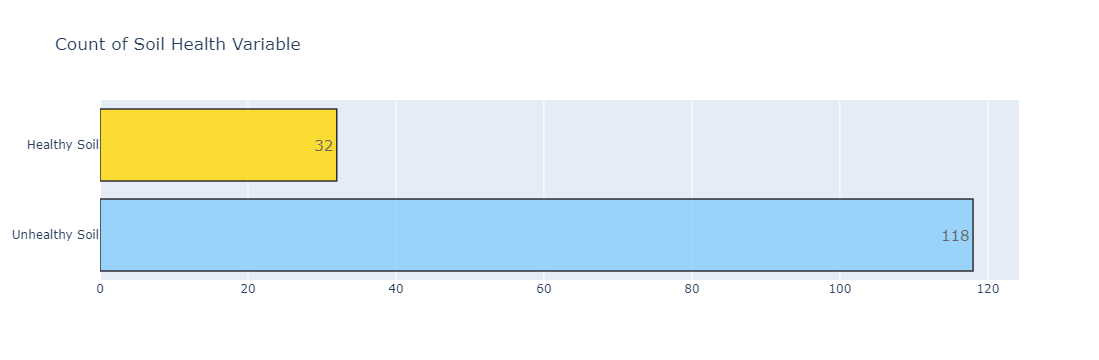

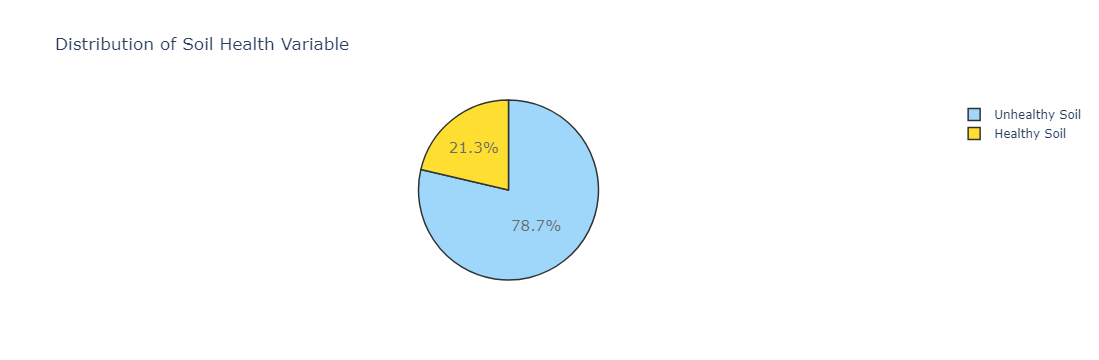

In [17]:
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
from sklearn.preprocessing import LabelEncoder

# Convert to DataFrame
df = pd.DataFrame(data)

# Encode Soil Health as numerical values
label_encoder = LabelEncoder()
df['Soil Health'] = label_encoder.fit_transform(df['Soil Health'])

# Display the first few rows of the DataFrame
df.head()

# Prepare datasets based on Soil Health
D = df[df['Soil Health'] != 0]  # Healthy Soil
H = df[df['Soil Health'] == 0]   # Unhealthy Soil

# ------------COUNT-----------------------
def target_count():
    # Count of Soil Health
    trace = go.Bar(
        x=df['Soil Health'].value_counts().values.tolist(), 
        y=['Unhealthy Soil', 'Healthy Soil'], 
        orientation='h', 
        text=df['Soil Health'].value_counts().values.tolist(), 
        textfont=dict(size=15),
        textposition='auto',
        opacity=0.8,
        marker=dict(
            color=['lightskyblue', 'gold'],
            line=dict(color='#000000', width=1.5)
        )
    )

    layout = dict(title='Count of Soil Health Variable')

    fig = dict(data=[trace], layout=layout)
    py.iplot(fig)

# ------------PERCENTAGE-------------------
def target_percent():
    # Percentage distribution of Soil Health
    trace = go.Pie(
        labels=['Unhealthy Soil', 'Healthy Soil'], 
        values=df['Soil Health'].value_counts(), 
        textfont=dict(size=15), 
        opacity=0.8,
        marker=dict(colors=['lightskyblue', 'gold'], 
                    line=dict(color='#000000', width=1.5))
    )

    layout = dict(title='Distribution of Soil Health Variable')

    fig = dict(data=[trace], layout=layout)
    py.iplot(fig)

# Call the functions to generate the plots
target_count()
target_percent()


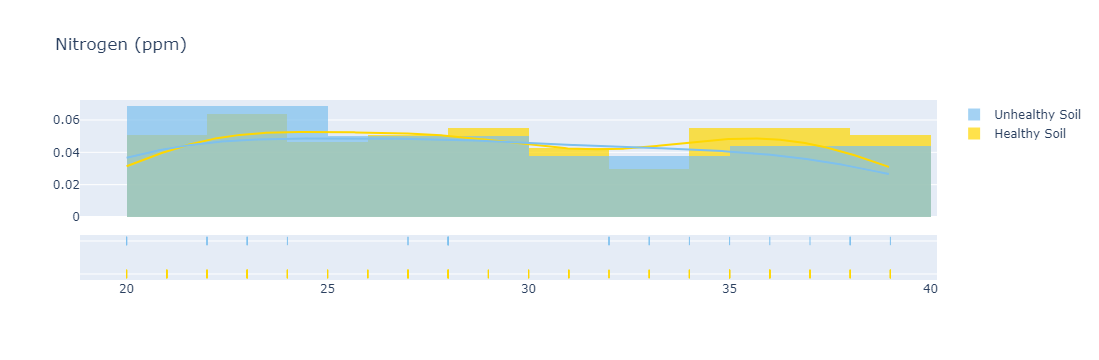

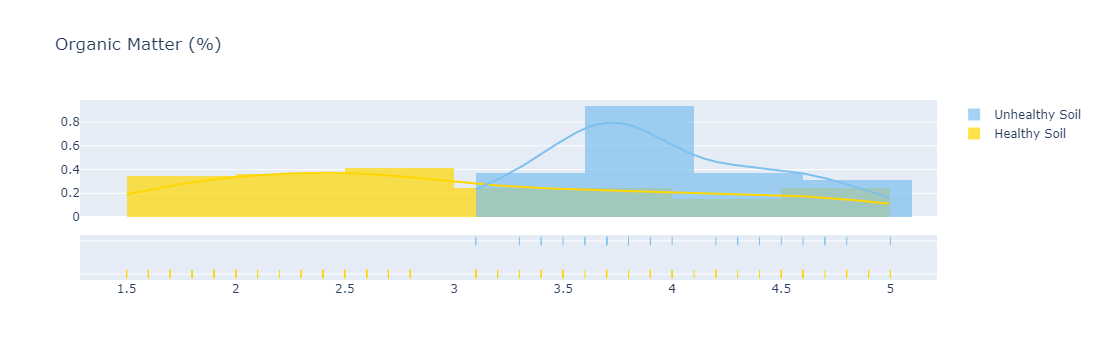

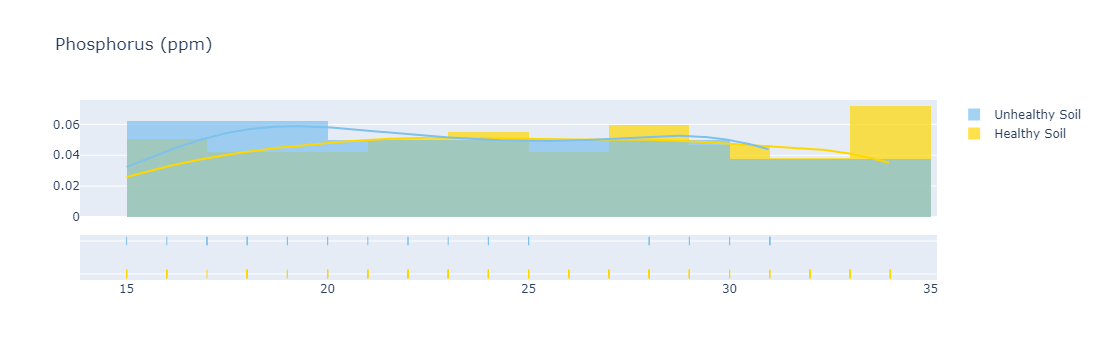

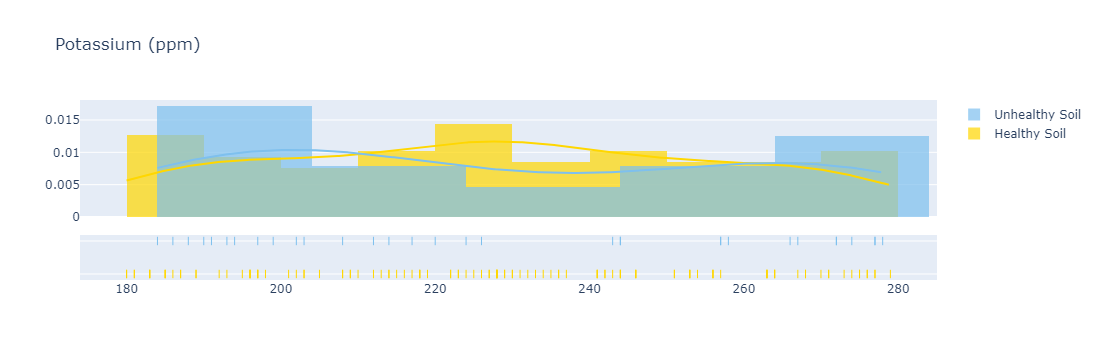

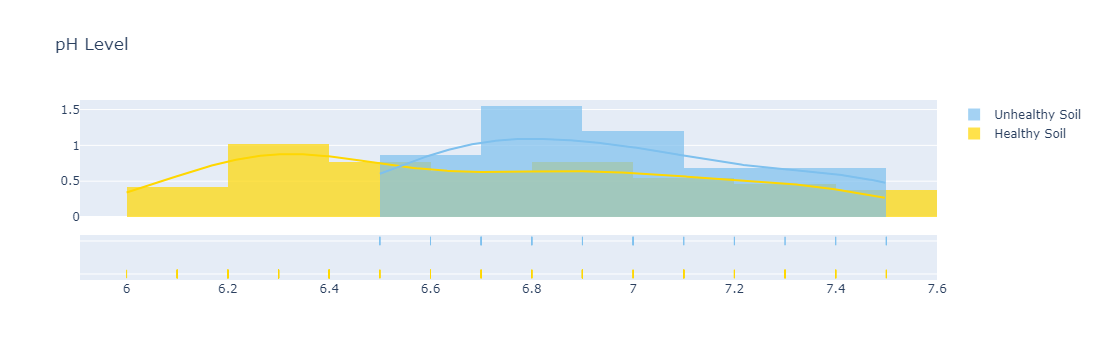

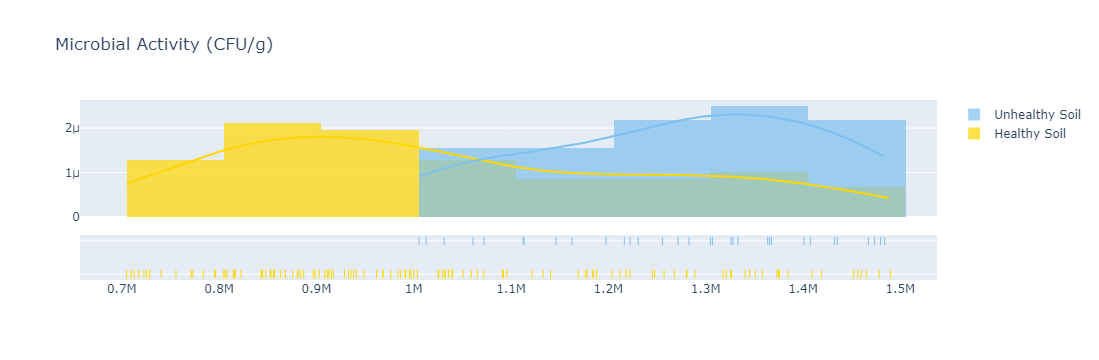

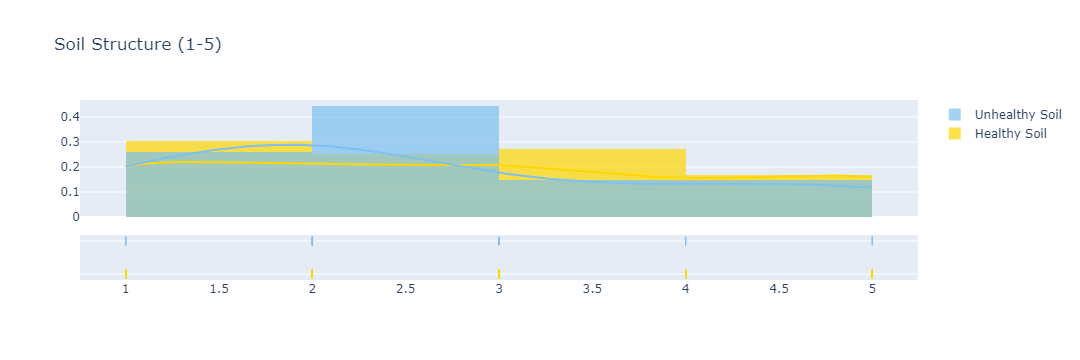

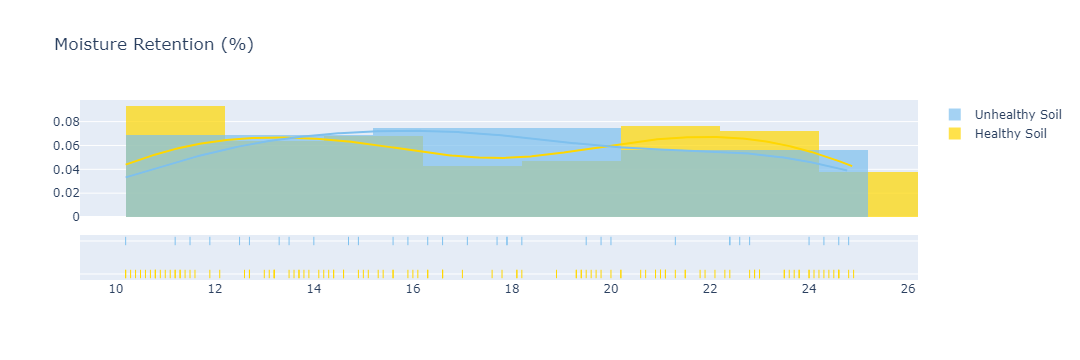

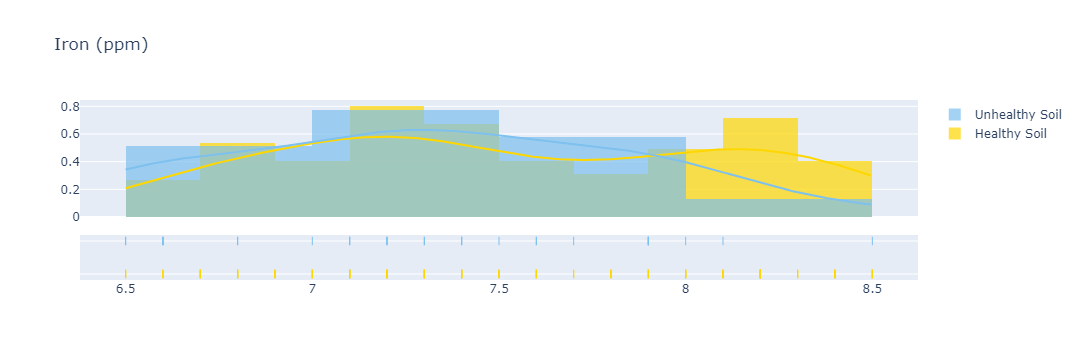

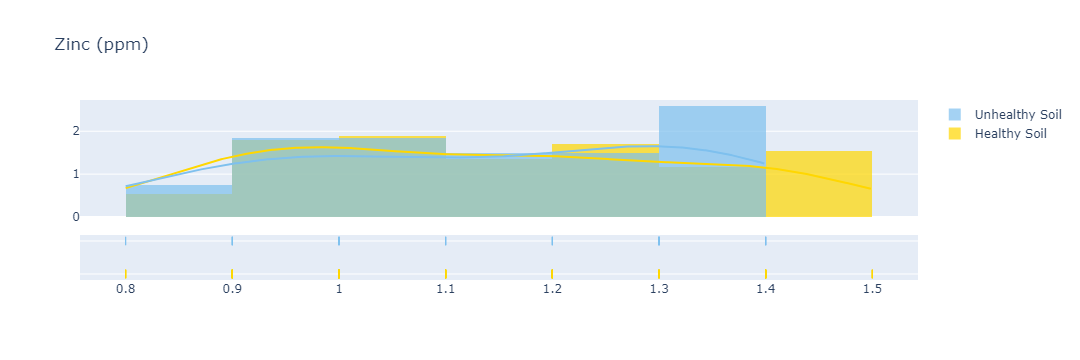

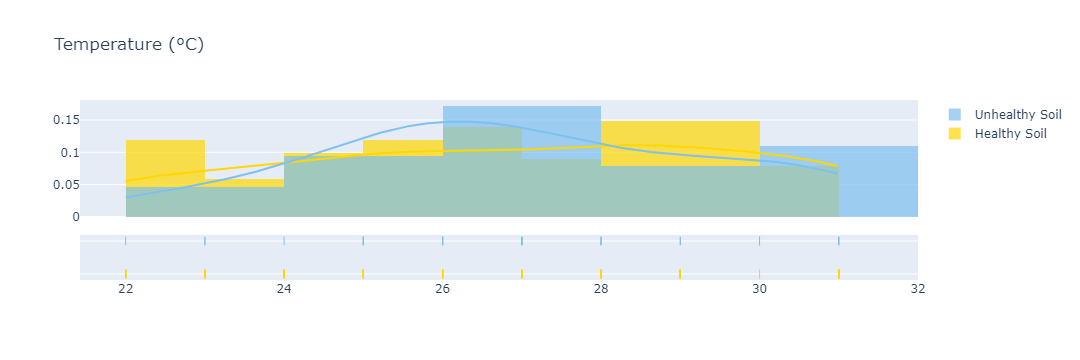

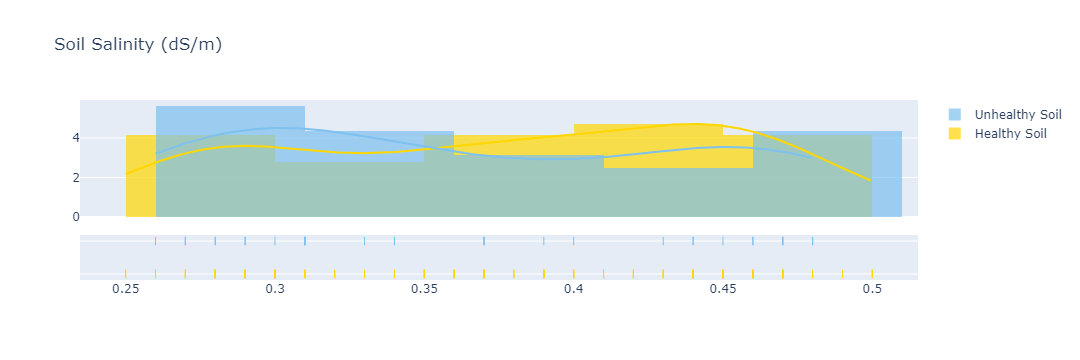

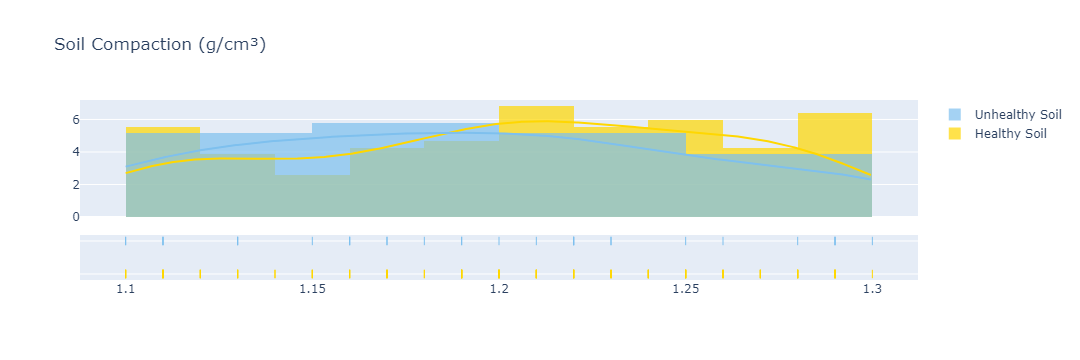

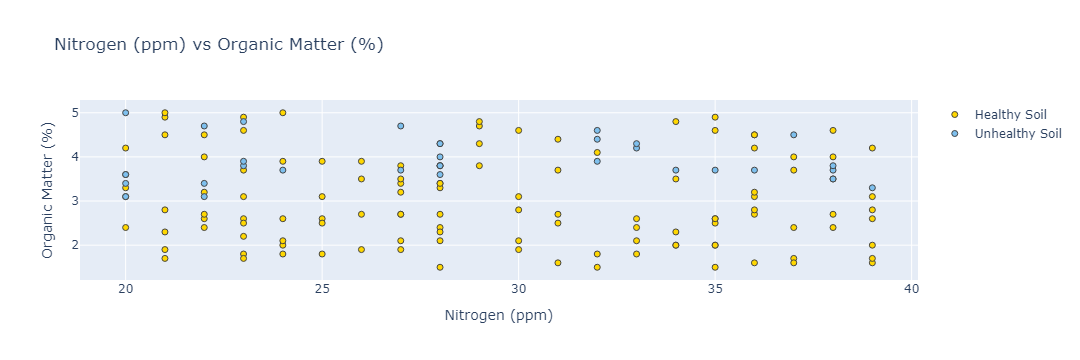

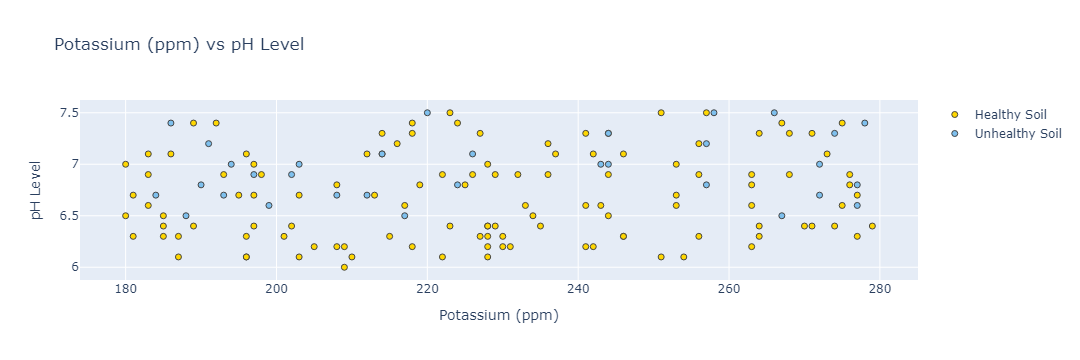

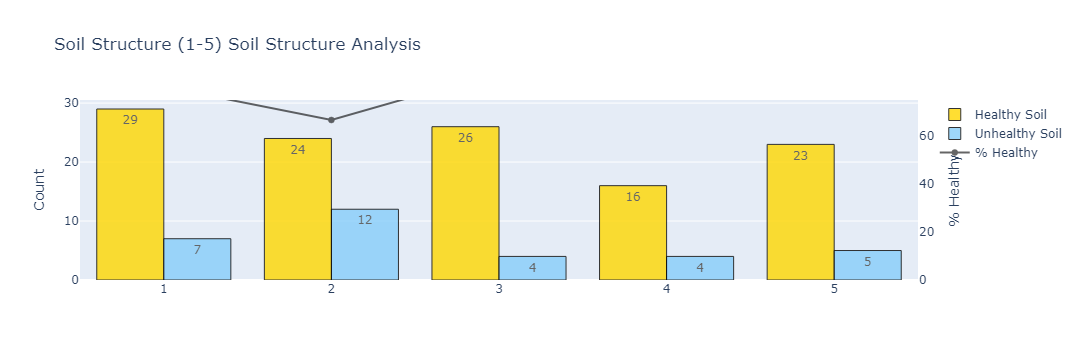

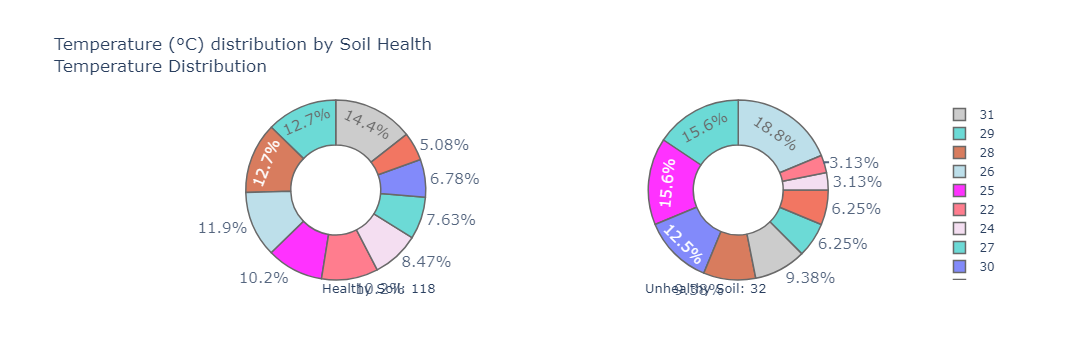

In [20]:
import pandas as pd
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.offline as py

# Prepare datasets based on Soil Health
D = df[df['Soil Health'] != 0]  # Healthy Soil
H = df[df['Soil Health'] == 0]   # Unhealthy Soil

# Function to calculate the median based on the soil health target variable
def median_target(var):
    temp = df[df[var].notnull()]
    temp = temp.groupby('Soil Health')[var].median().reset_index()
    return temp

# Function to plot the distribution of a selected variable
def plot_distribution(data_select, size_bin):
    D = df[df['Soil Health'] != 0][data_select].dropna()  # Healthy Soil
    H = df[df['Soil Health'] == 0][data_select].dropna()  # Unhealthy Soil

    # Check if both datasets are not empty
    if D.empty or H.empty:
        print(f"Warning: No data available for {data_select}.")
        return  # Exit the function if there's no data to plot

    hist_data = [D, H]
    group_labels = ['Healthy Soil', 'Unhealthy Soil']
    colors = ['#FFD700', '#7EC0EE']

    fig = ff.create_distplot(hist_data, group_labels, colors=colors, show_hist=True, bin_size=size_bin, curve_type='kde')
    fig['layout'].update(title=data_select)
    py.iplot(fig, filename='Density plot')

# Function to handle missing values for specific variables
def fill_missing_values(var, healthy_value, unhealthy_value):
    df.loc[(df['Soil Health'] == 0) & (df[var].isnull()), var] = unhealthy_value
    df.loc[(df['Soil Health'] == 1) & (df[var].isnull()), var] = healthy_value

# Update for each variable in the new dataset
variables = {
    'Nitrogen (ppm)': (20.0, 35.0),
    'Organic Matter (%)': (3.5, 5.0),
    'Phosphorus (ppm)': (15.0, 25.0),
    'Potassium (ppm)': (180.0, 220.0),
    'pH Level': (5.5, 6.5),  # Adjust these values as needed
    'Microbial Activity (CFU/g)': (50000, 80000),  # Example values
    'Soil Structure (1-5)': (2, 4),  # Example values
    'Moisture Retention (%)': (30, 50),  # Example values
    'Iron (ppm)': (10, 20),  # Example values
    'Zinc (ppm)': (1, 2),  # Example values
    'Temperature (°C)': (15, 20),  # Example values
    'Soil Salinity (dS/m)': (0.5, 1.0),  # Example values
    'Soil Compaction (g/cm³)': (1.2, 1.5)  # Example values
}

for var, (unhealthy_value, healthy_value) in variables.items():
    median_target(var)
    fill_missing_values(var, healthy_value, unhealthy_value)
    plot_distribution(var, 0)  # Adjust bin size as necessary


# Sample distribution plots for pairs of features
def plot_feat1_feat2(feat1, feat2):
    D = df[df['Soil Health'] != 0]  # Healthy Soil
    H = df[df['Soil Health'] == 0]  # Unhealthy Soil

    if D.empty or H.empty:
        print(f"Warning: No data available for features: {feat1} and {feat2}.")
        return  # Exit if there's no data to plot

    trace0 = go.Scatter(
        x=D[feat1],
        y=D[feat2],
        name='Healthy Soil',
        mode='markers', 
        marker=dict(color='#FFD700', line=dict(width=1))
    )

    trace1 = go.Scatter(
        x=H[feat1],
        y=H[feat2],
        name='Unhealthy Soil',
        mode='markers',
        marker=dict(color='#7EC0EE', line=dict(width=1))
    )

    layout = dict(title=f"{feat1} vs {feat2}",
                  yaxis=dict(title=feat2, zeroline=False),
                  xaxis=dict(title=feat1, zeroline=False))

    fig = dict(data=[trace0, trace1], layout=layout)
    py.iplot(fig)

# Call to plot feature pairs
plot_feat1_feat2('Nitrogen (ppm)', 'Organic Matter (%)')
plot_feat1_feat2('Potassium (ppm)', 'pH Level')

# Function to create a bar plot for categorical variables
def barplot(var_select, sub):
    tmp1 = df[df['Soil Health'] != 0]
    tmp2 = df[df['Soil Health'] == 0]
    
    tmp3 = pd.crosstab(df[var_select], df['Soil Health'])
    tmp3['% Healthy'] = tmp3[1] / (tmp3[1] + tmp3[0]) * 100

    trace1 = go.Bar(
        x=tmp1[var_select].value_counts().index,
        y=tmp1[var_select].value_counts().values,
        text=tmp1[var_select].value_counts().values,
        textposition='auto',
        name='Healthy Soil', 
        opacity=0.8, 
        marker=dict(color='gold', line=dict(color='#000000', width=1))
    )

    trace2 = go.Bar(
        x=tmp2[var_select].value_counts().index,
        y=tmp2[var_select].value_counts().values,
        text=tmp2[var_select].value_counts().values,
        textposition='auto',
        name='Unhealthy Soil', 
        opacity=0.8, 
        marker=dict(color='lightskyblue', line=dict(color='#000000', width=1))
    )

    trace3 = go.Scatter(
        x=tmp3.index,
        y=tmp3['% Healthy'],
        yaxis='y2',
        name='% Healthy', 
        opacity=0.6, 
        marker=dict(color='black', line=dict(color='#000000', width=0.5))
    )

    layout = dict(title=str(var_select) + ' ' + (sub),
                  xaxis=dict(),
                  yaxis=dict(title='Count'),
                  yaxis2=dict(range=[0, 75],
                              overlaying='y',
                              anchor='x',
                              side='right',
                              zeroline=False,
                              showgrid=False,
                              title='% Healthy'))

    fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
    py.iplot(fig)

# Sample barplot call
barplot('Soil Structure (1-5)', 'Soil Structure Analysis')

# Function to create pie chart
def plot_pie(var_select, sub):
    D = df[df['Soil Health'] != 0]
    H = df[df['Soil Health'] == 0]

    col = ['Silver', 'mediumturquoise', '#CF5C36', 'lightblue', 'magenta', '#FF5D73', '#F2D7EE', 'mediumturquoise']
    
    trace1 = go.Pie(values=D[var_select].value_counts(),
                    labels=D[var_select].value_counts().index,
                    textfont=dict(size=15), opacity=0.8,
                    hole=0.5,
                    hoverinfo="label+percent+name",
                    domain=dict(x=[.0, .48]),
                    name="Healthy Soil",
                    marker=dict(colors=col, line=dict(width=1.5)))

    trace2 = go.Pie(values=H[var_select].value_counts(),
                    labels=H[var_select].value_counts().index,
                    textfont=dict(size=15), opacity=0.8,
                    hole=0.5,
                    hoverinfo="label+percent+name",
                    marker=dict(line=dict(width=1.5)),
                    domain=dict(x=[.52, 1]),
                    name="Unhealthy Soil")

    layout = go.Layout(dict(title=var_select + " distribution by Soil Health <br>" + (sub),
                            annotations=[dict(text="Healthy Soil: " + str(len(D)),
                                              font=dict(size=13),
                                              showarrow=False,
                                              x=.22, y=-0.1),
                                         dict(text="Unhealthy Soil: " + str(len(H)),
                                              font=dict(size=13),
                                              showarrow=False,
                                              x=.8, y=-.1)]))

    fig = go.Figure(data=[trace1, trace2], layout=layout)
    py.iplot(fig)

# Sample pie chart call
plot_pie('Temperature (°C)', 'Temperature Distribution')


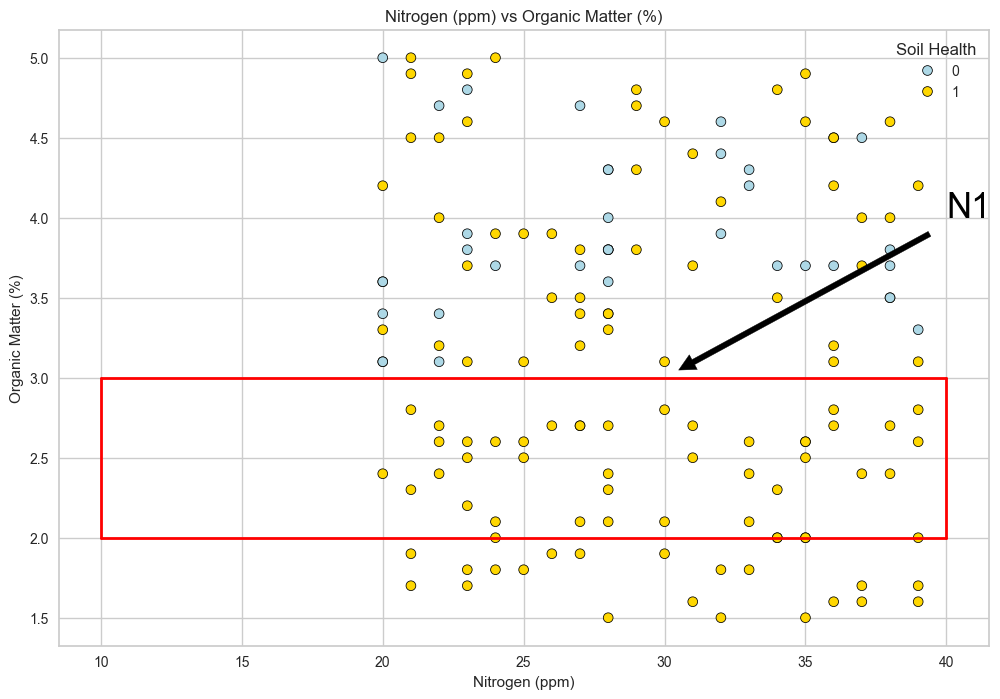

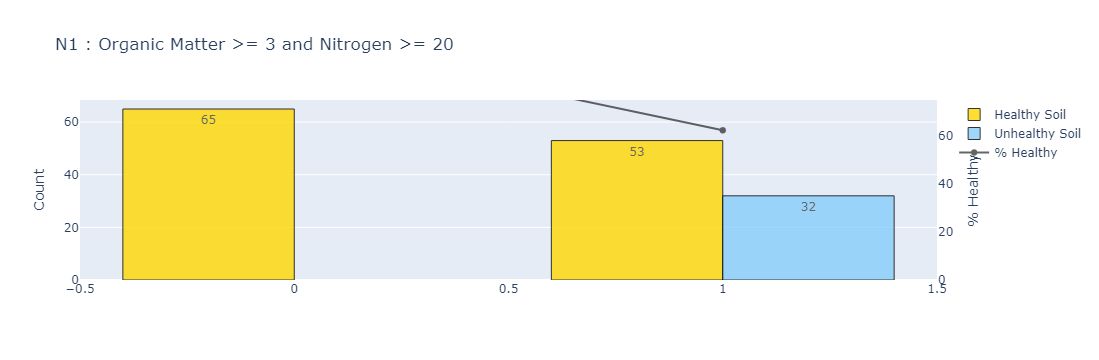

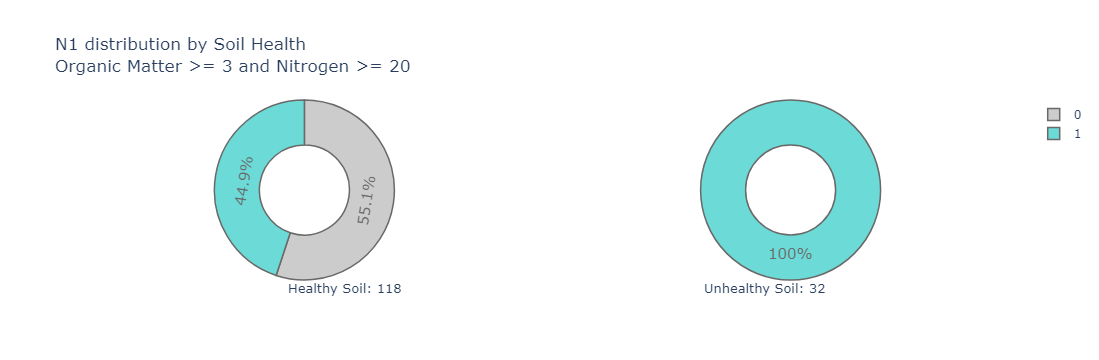

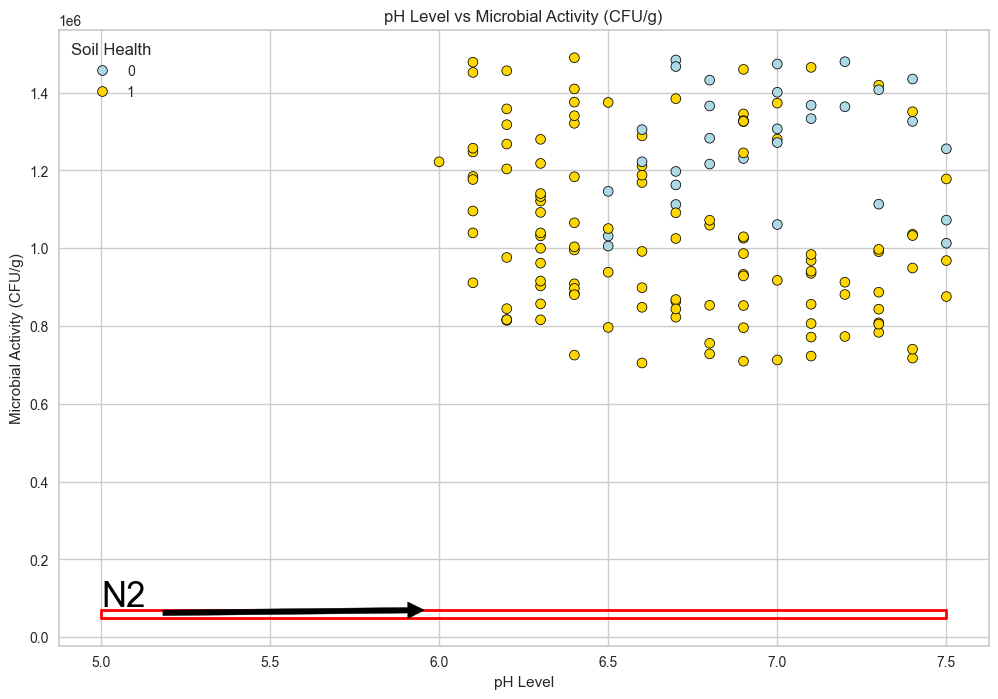

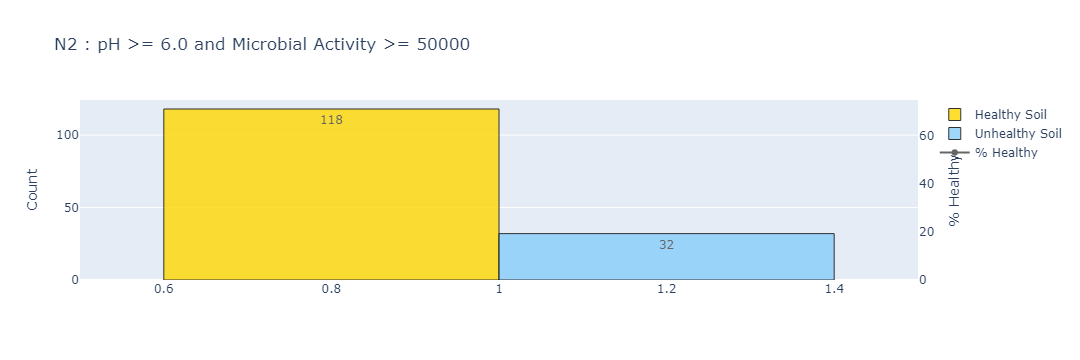

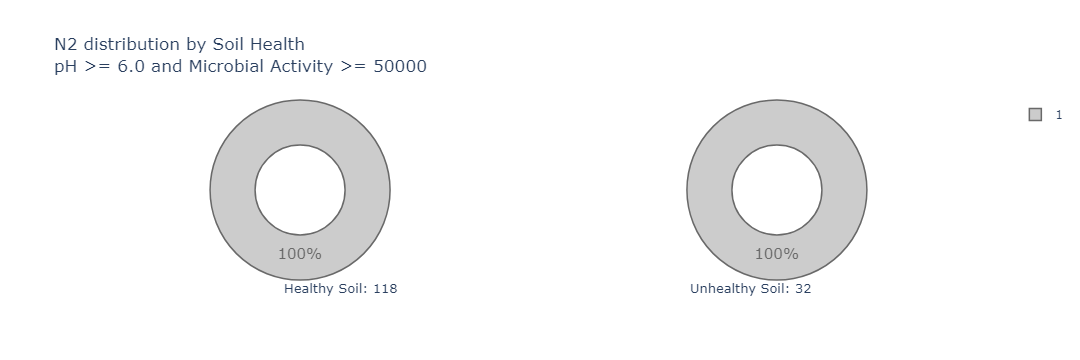

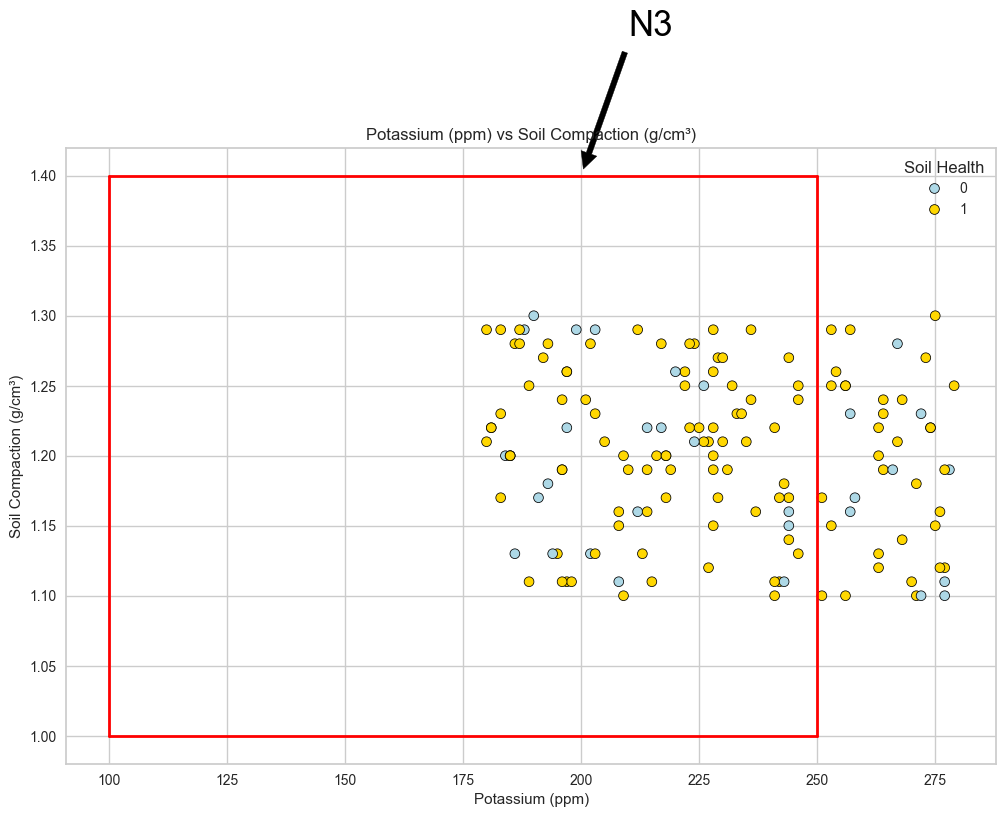

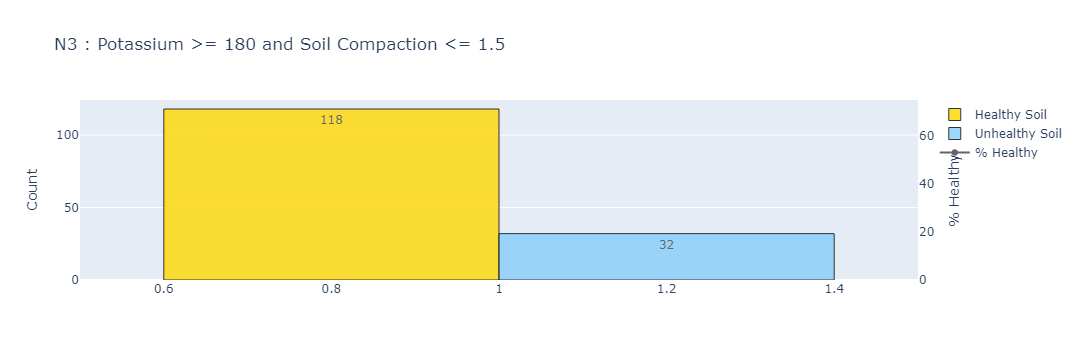

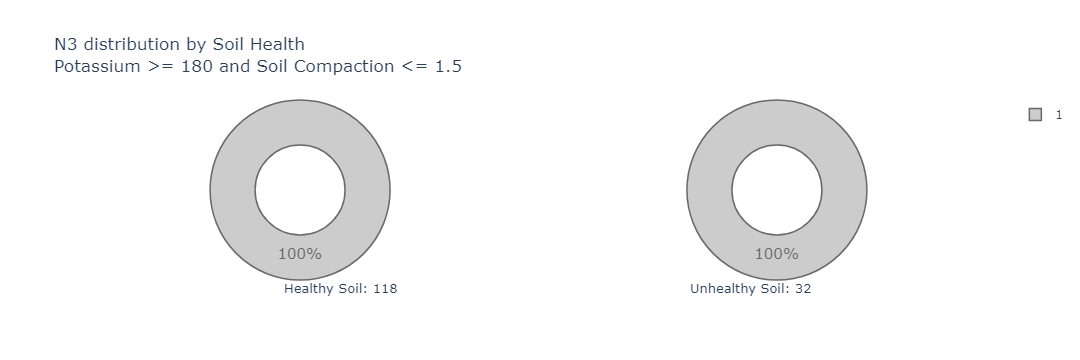

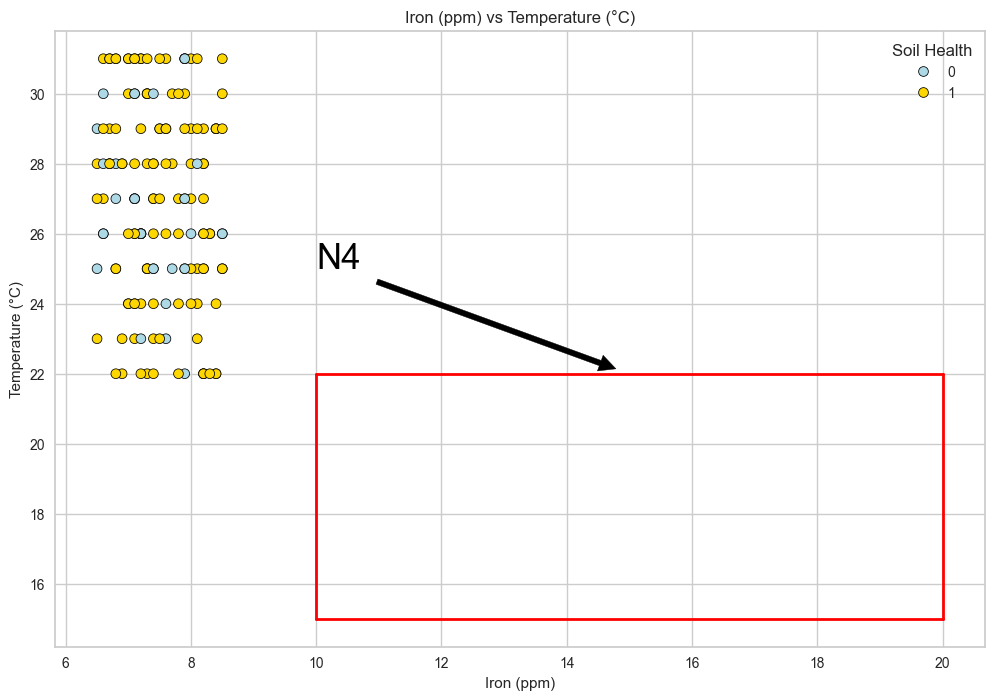

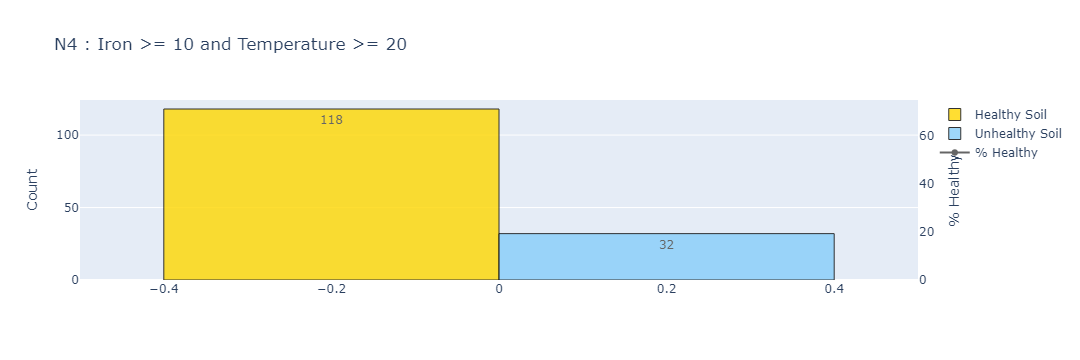

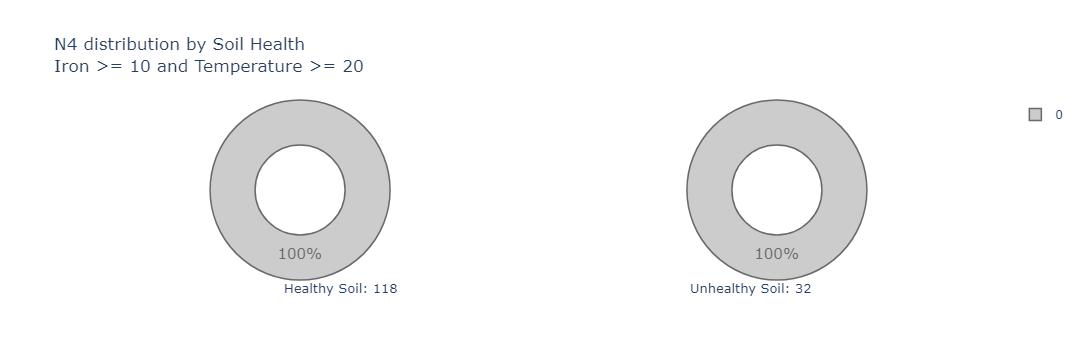

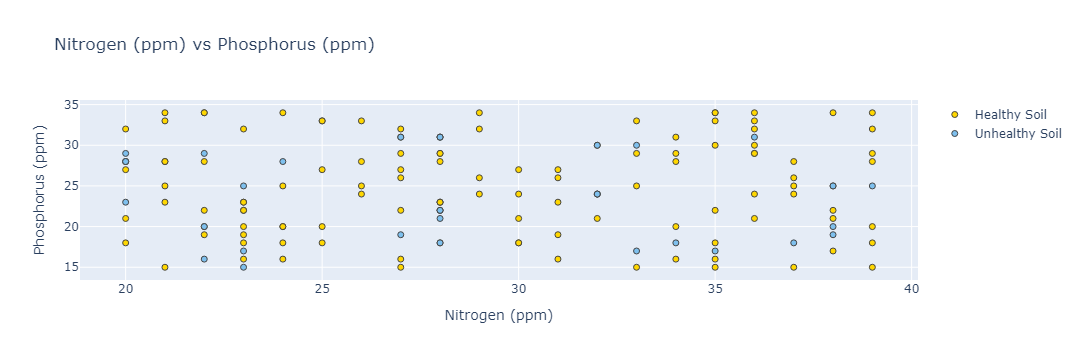

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame with soil health information
data = df  # Use your updated DataFrame name if it's different

# Define color palette for the soil health outcomes
palette = {0: 'lightblue', 1: 'gold'}
edgecolor = 'black'

# Create a scatter plot for Nitrogen (ppm) vs Organic Matter (%)
fig = plt.figure(figsize=(12, 8))
ax1 = sns.scatterplot(x=data['Nitrogen (ppm)'], y=data['Organic Matter (%)'], hue="Soil Health",
                       data=data, palette=palette, edgecolor=edgecolor)

plt.annotate('N1', size=25, color='black', xy=(30, 3), xytext=(40, 4),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.plot([10, 40], [3, 3], linewidth=2, color='red')
plt.plot([40, 40], [2, 3], linewidth=2, color='red')
plt.plot([10, 40], [2, 2], linewidth=2, color='red')
plt.plot([10, 10], [2, 3], linewidth=2, color='red')
plt.title('Nitrogen (ppm) vs Organic Matter (%)')
plt.show()

# Create a new feature based on Nitrogen and Organic Matter
data.loc[:, 'N1'] = 0
data.loc[(data['Organic Matter (%)'] >= 3) & (data['Nitrogen (ppm)'] >= 20), 'N1'] = 1
barplot('N1', ': Organic Matter >= 3 and Nitrogen >= 20')
plot_pie('N1', 'Organic Matter >= 3 and Nitrogen >= 20')

# Create a scatter plot for pH Level vs Microbial Activity (CFU/g)
fig = plt.figure(figsize=(12, 8))
ax2 = sns.scatterplot(x=data['pH Level'], y=data['Microbial Activity (CFU/g)'], hue="Soil Health",
                       data=data, palette=palette, edgecolor=edgecolor)

plt.annotate('N2', size=25, color='black', xy=(6.0, 70000), xytext=(5.0, 80000),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.plot([5.0, 7.5], [70000, 70000], linewidth=2, color='red')
plt.plot([7.5, 7.5], [50000, 70000], linewidth=2, color='red')
plt.plot([5.0, 7.5], [50000, 50000], linewidth=2, color='red')
plt.plot([5.0, 5.0], [50000, 70000], linewidth=2, color='red')
plt.title('pH Level vs Microbial Activity (CFU/g)')
plt.show()

# Create a new feature based on pH and Microbial Activity
data.loc[:, 'N2'] = 0
data.loc[(data['pH Level'] >= 6.0) & (data['Microbial Activity (CFU/g)'] >= 50000), 'N2'] = 1
barplot('N2', ': pH >= 6.0 and Microbial Activity >= 50000')
plot_pie('N2', 'pH >= 6.0 and Microbial Activity >= 50000')

# Create a scatter plot for Potassium (ppm) vs Soil Compaction (g/cm³)
fig = plt.figure(figsize=(12, 8))
ax3 = sns.scatterplot(x=data['Potassium (ppm)'], y=data['Soil Compaction (g/cm³)'], hue="Soil Health",
                       data=data, palette=palette, edgecolor=edgecolor)

plt.annotate('N3', size=25, color='black', xy=(200, 1.4), xytext=(210, 1.5),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.plot([100, 250], [1.4, 1.4], linewidth=2, color='red')
plt.plot([250, 250], [1.0, 1.4], linewidth=2, color='red')
plt.plot([100, 250], [1.0, 1.0], linewidth=2, color='red')
plt.plot([100, 100], [1.0, 1.4], linewidth=2, color='red')
plt.title('Potassium (ppm) vs Soil Compaction (g/cm³)')
plt.show()

# Create a new feature based on Potassium and Soil Compaction
data.loc[:, 'N3'] = 0
data.loc[(data['Potassium (ppm)'] >= 180) & (data['Soil Compaction (g/cm³)'] <= 1.5), 'N3'] = 1
barplot('N3', ': Potassium >= 180 and Soil Compaction <= 1.5')
plot_pie('N3', 'Potassium >= 180 and Soil Compaction <= 1.5')

# Create a scatter plot for Iron (ppm) vs Temperature (°C)
fig = plt.figure(figsize=(12, 8))
ax4 = sns.scatterplot(x=data['Iron (ppm)'], y=data['Temperature (°C)'], hue="Soil Health",
                       data=data, palette=palette, edgecolor=edgecolor)

plt.annotate('N4', size=25, color='black', xy=(15, 22), xytext=(10, 25),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.plot([10, 20], [22, 22], linewidth=2, color='red')
plt.plot([20, 20], [15, 22], linewidth=2, color='red')
plt.plot([10, 20], [15, 15], linewidth=2, color='red')
plt.plot([10, 10], [15, 22], linewidth=2, color='red')
plt.title('Iron (ppm) vs Temperature (°C)')
plt.show()

# Create a new feature based on Iron and Temperature
data.loc[:, 'N4'] = 0
data.loc[(data['Iron (ppm)'] >= 10) & (data['Temperature (°C)'] >= 20), 'N4'] = 1
barplot('N4', ': Iron >= 10 and Temperature >= 20')
plot_pie('N4', 'Iron >= 10 and Temperature >= 20')

# Call the feature pair plot function for additional analysis
plot_feat1_feat2('Nitrogen (ppm)', 'Phosphorus (ppm)')


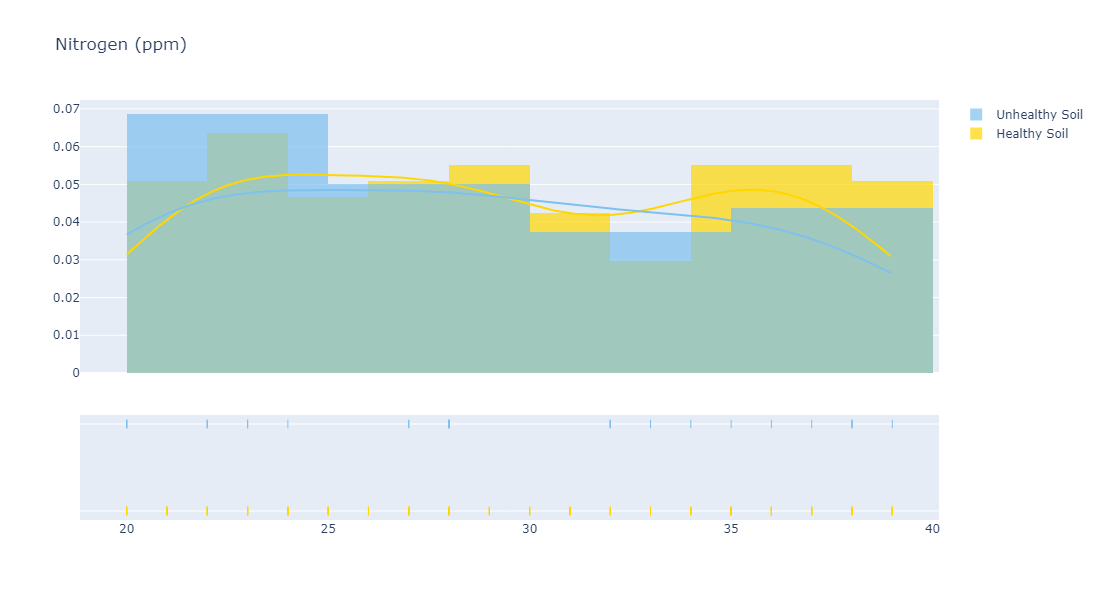

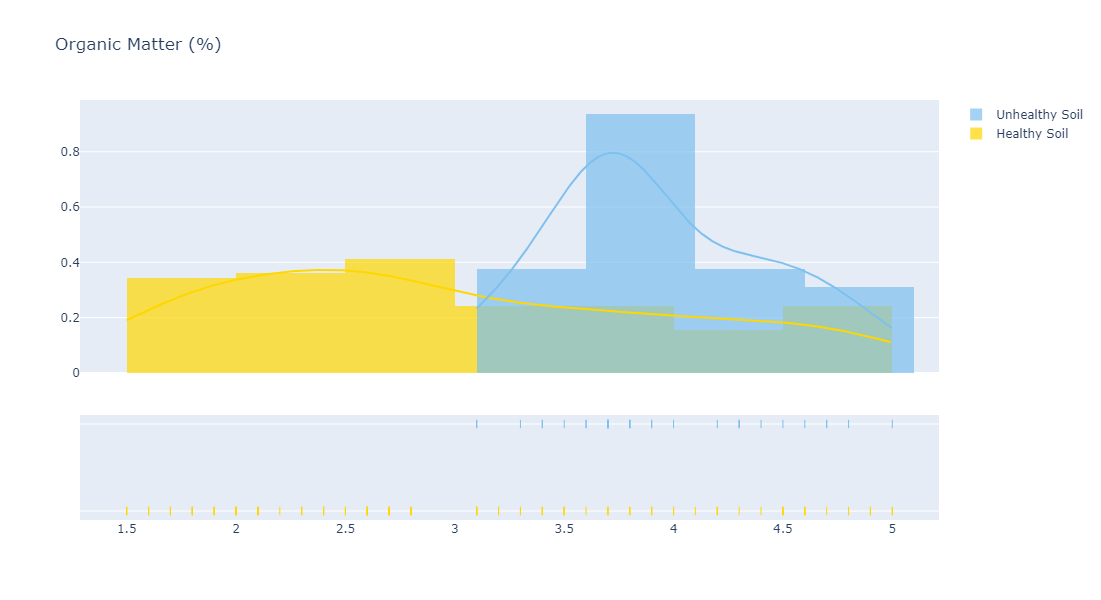

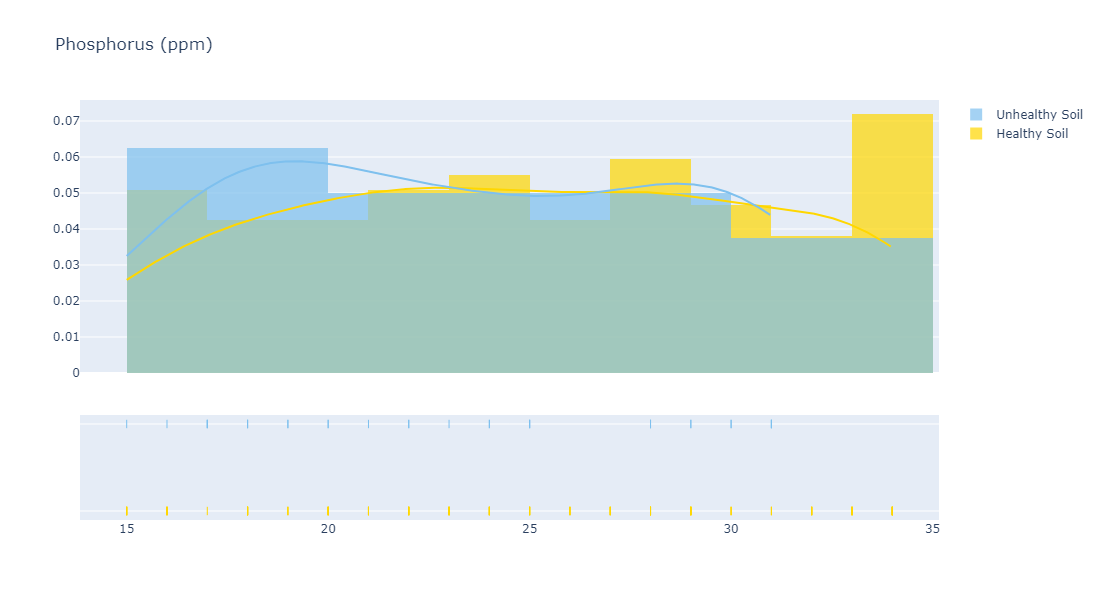

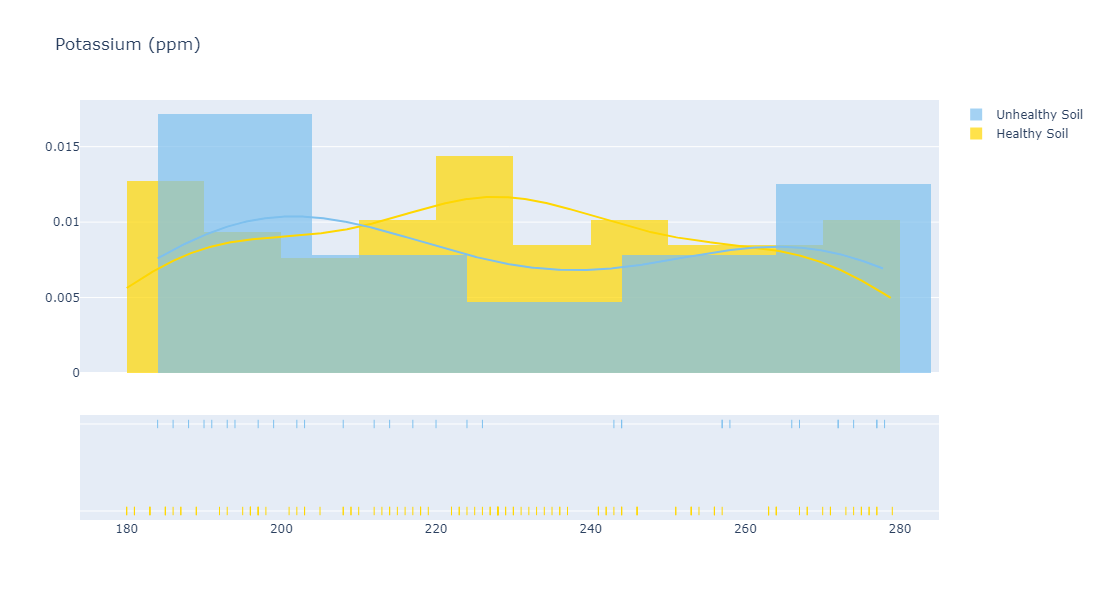

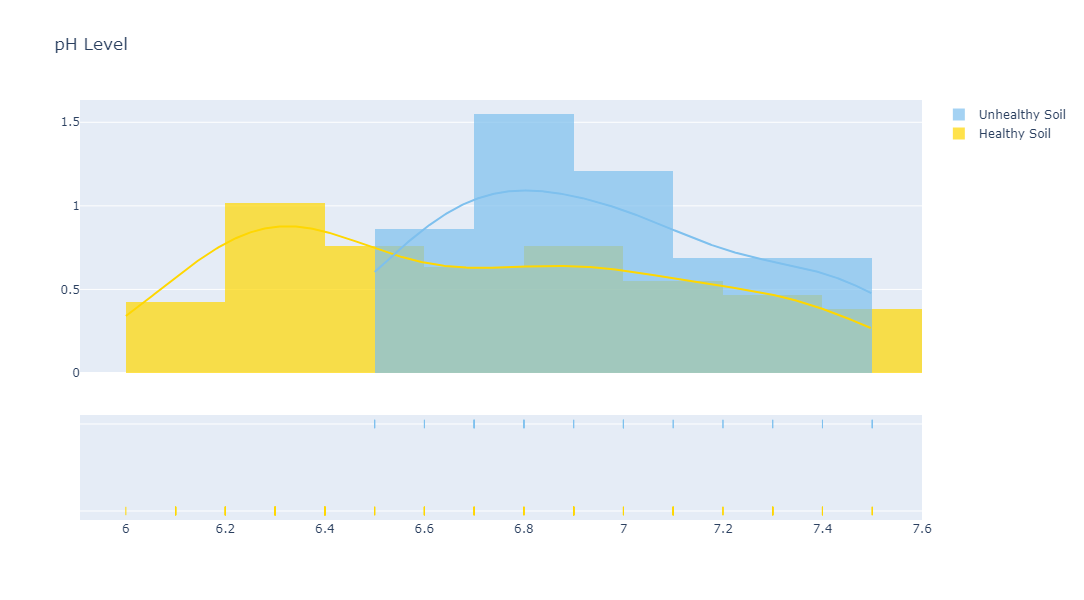

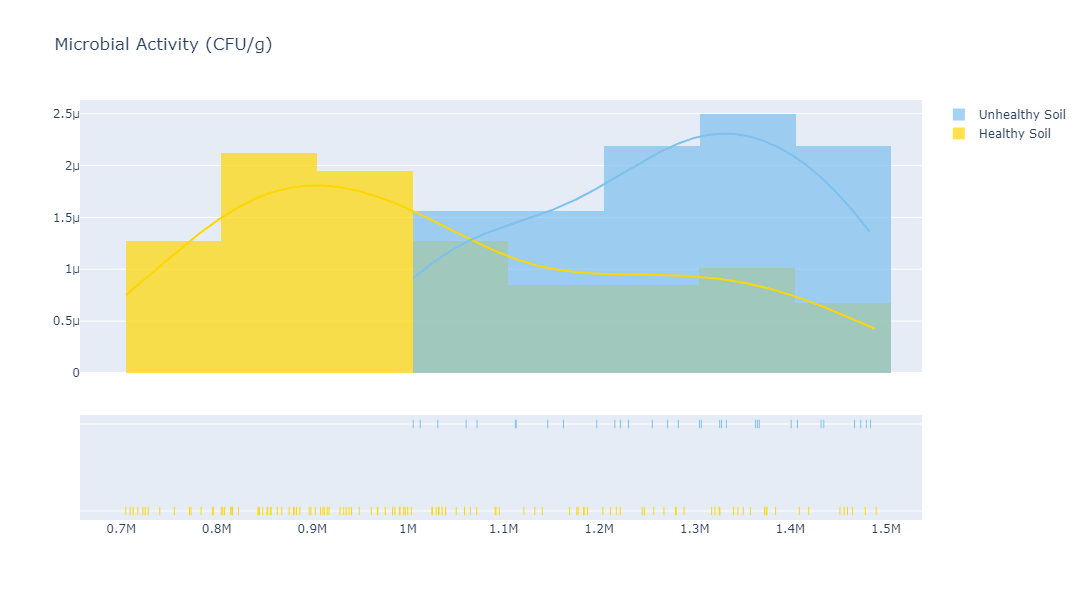

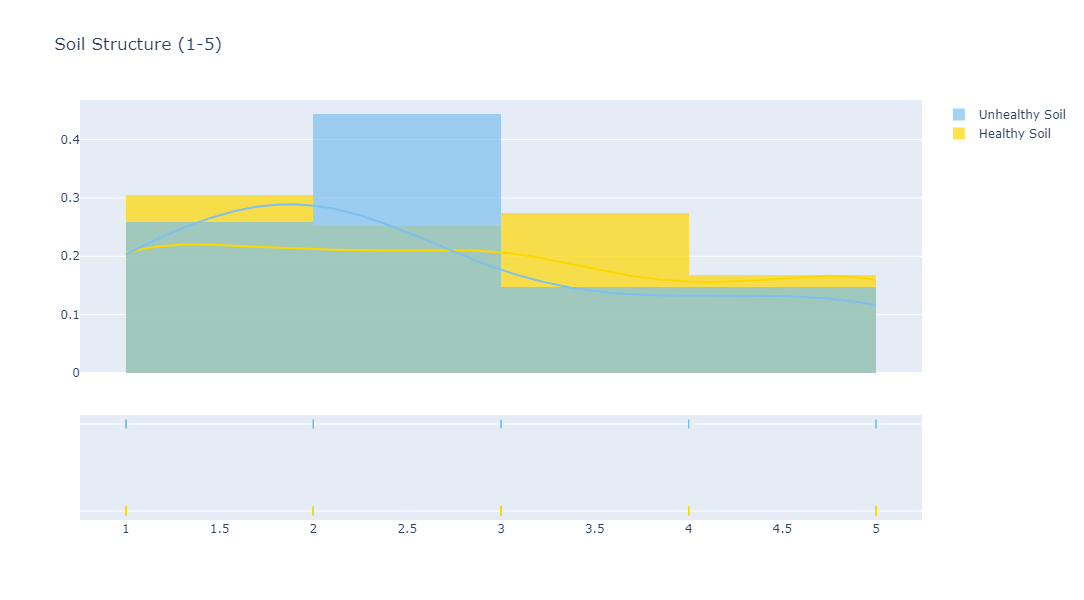

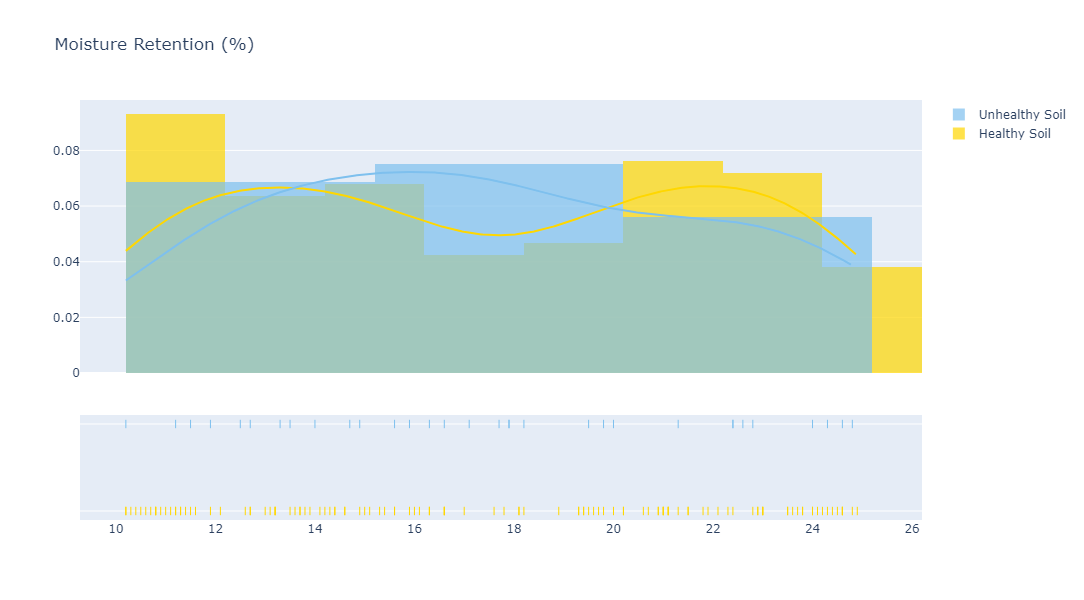

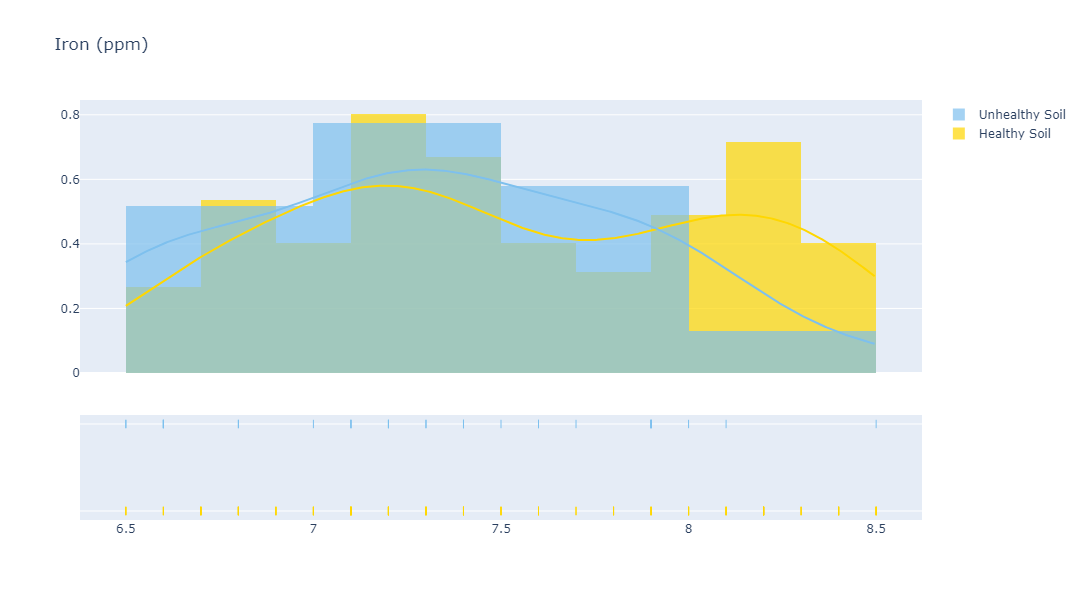

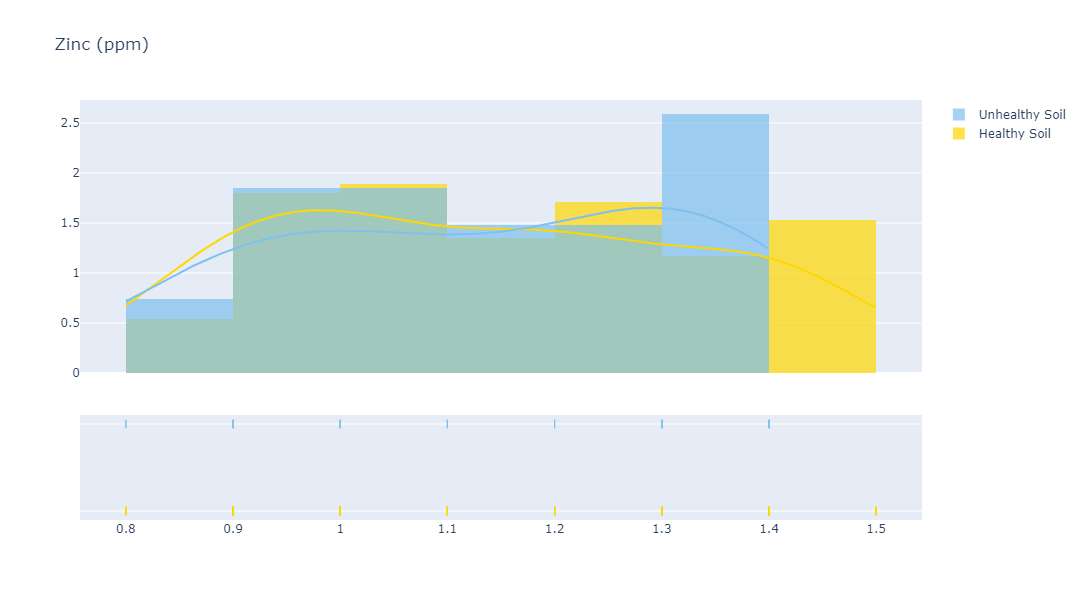

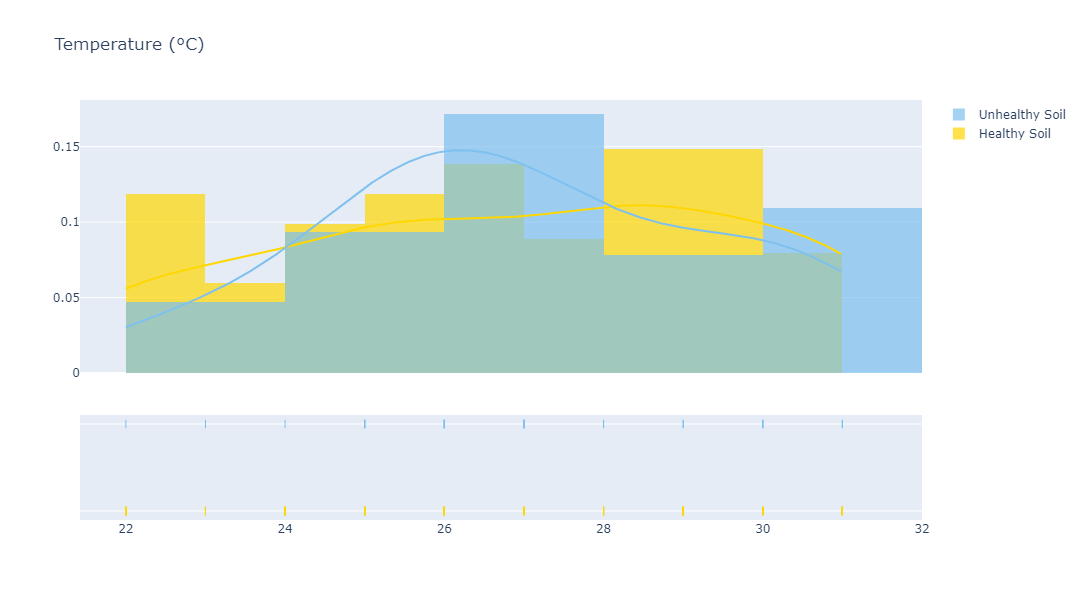

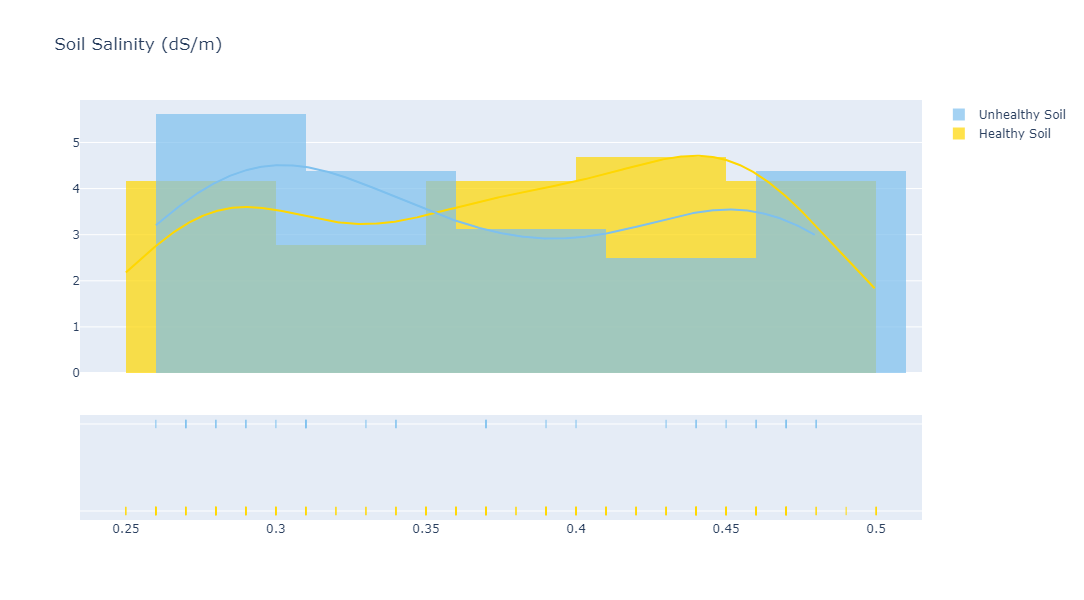

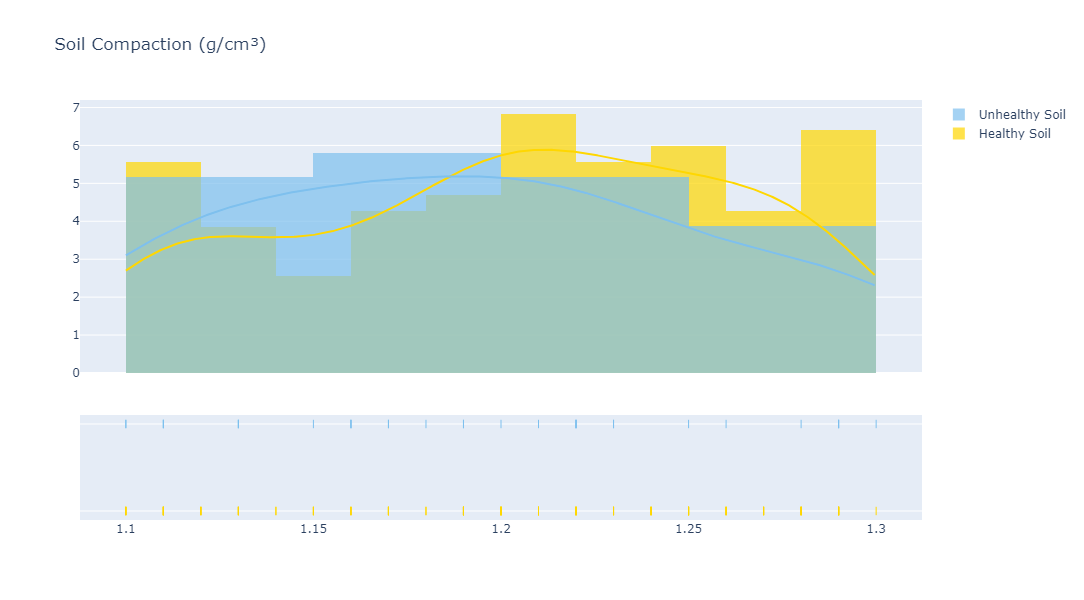

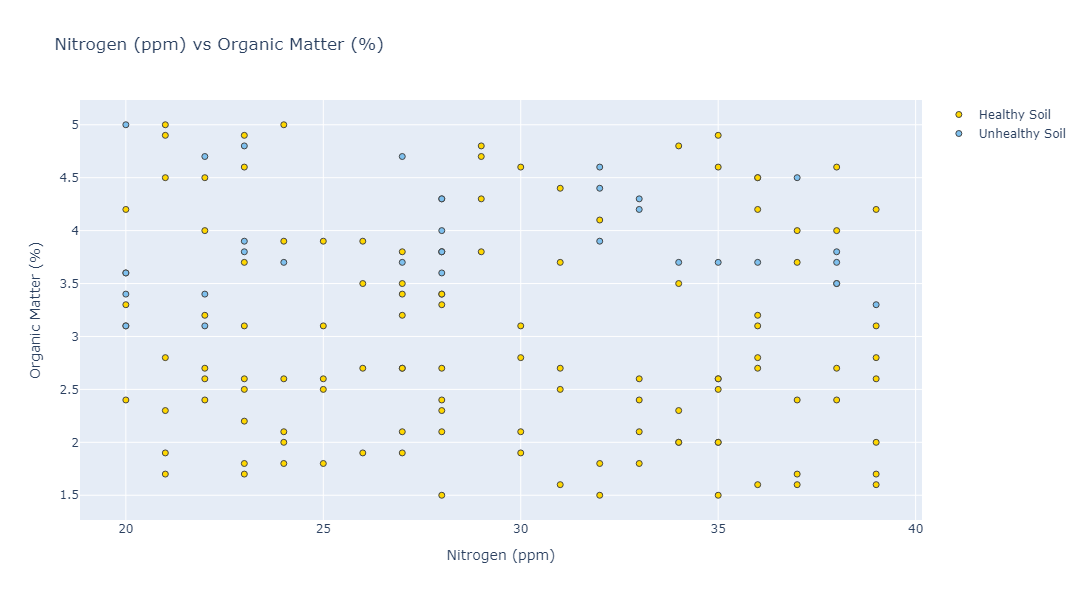

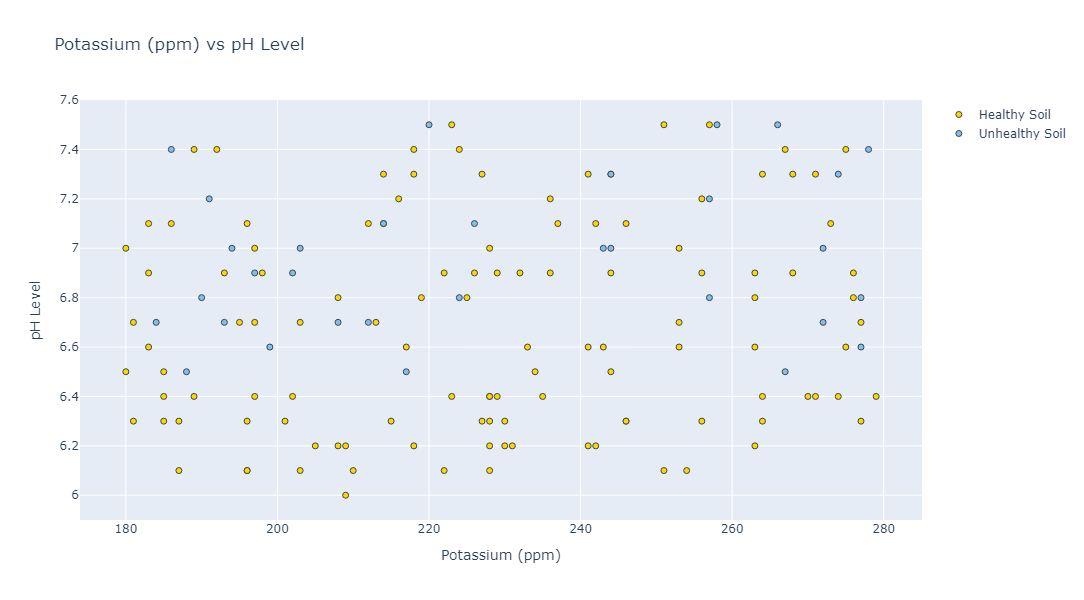

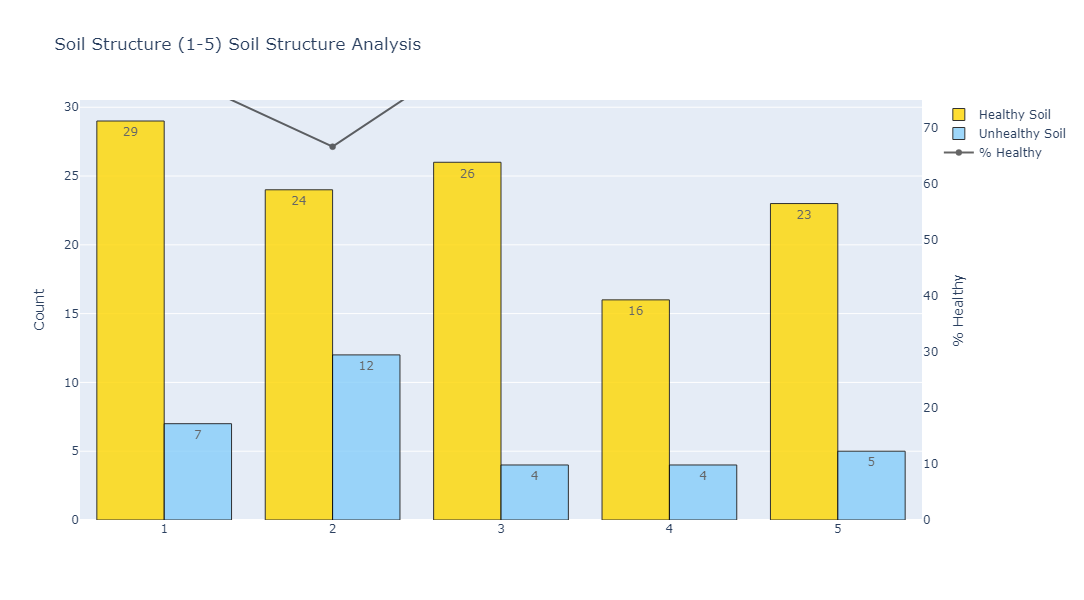

In [22]:
import pandas as pd
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.offline as py

# Prepare datasets based on Soil Health
D = df[df['Soil Health'] != 0]  # Healthy Soil
H = df[df['Soil Health'] == 0]   # Unhealthy Soil

# Function to calculate the median based on the soil health target variable
def median_target(var):
    temp = df[df[var].notnull()]
    temp = temp.groupby('Soil Health')[var].median().reset_index()
    return temp

# Function to plot the distribution of a selected variable
def plot_distribution(data_select, size_bin):
    D = df[df['Soil Health'] != 0][data_select].dropna()  # Healthy Soil
    H = df[df['Soil Health'] == 0][data_select].dropna()  # Unhealthy Soil

    # Check if both datasets are not empty
    if D.empty or H.empty:
        print(f"Warning: No data available for {data_select}.")
        return  # Exit the function if there's no data to plot

    hist_data = [D, H]
    group_labels = ['Healthy Soil', 'Unhealthy Soil']
    colors = ['#FFD700', '#7EC0EE']

    fig = ff.create_distplot(hist_data, group_labels, colors=colors, show_hist=True, bin_size=size_bin, curve_type='kde')
    fig['layout'].update(title=data_select, width=600, height=600)  # Adjusted width and height
    py.iplot(fig, filename='Density plot')

# Function to handle missing values for specific variables
def fill_missing_values(var, healthy_value, unhealthy_value):
    df.loc[(df['Soil Health'] == 0) & (df[var].isnull()), var] = unhealthy_value
    df.loc[(df['Soil Health'] == 1) & (df[var].isnull()), var] = healthy_value

# Update for each variable in the new dataset
variables = {
    'Nitrogen (ppm)': (20.0, 35.0),
    'Organic Matter (%)': (3.5, 5.0),
    'Phosphorus (ppm)': (15.0, 25.0),
    'Potassium (ppm)': (180.0, 220.0),
    'pH Level': (5.5, 6.5),  # Adjust these values as needed
    'Microbial Activity (CFU/g)': (50000, 80000),  # Example values
    'Soil Structure (1-5)': (2, 4),  # Example values
    'Moisture Retention (%)': (30, 50),  # Example values
    'Iron (ppm)': (10, 20),  # Example values
    'Zinc (ppm)': (1, 2),  # Example values
    'Temperature (°C)': (15, 20),  # Example values
    'Soil Salinity (dS/m)': (0.5, 1.0),  # Example values
    'Soil Compaction (g/cm³)': (1.2, 1.5)  # Example values
}

for var, (unhealthy_value, healthy_value) in variables.items():
    median_target(var)
    fill_missing_values(var, healthy_value, unhealthy_value)
    plot_distribution(var, 0)  # Adjust bin size as necessary

# Sample distribution plots for pairs of features
def plot_feat1_feat2(feat1, feat2):
    D = df[df['Soil Health'] != 0]  # Healthy Soil
    H = df[df['Soil Health'] == 0]  # Unhealthy Soil

    if D.empty or H.empty:
        print(f"Warning: No data available for features: {feat1} and {feat2}.")
        return  # Exit if there's no data to plot

    trace0 = go.Scatter(
        x=D[feat1],
        y=D[feat2],
        name='Healthy Soil',
        mode='markers', 
        marker=dict(color='#FFD700', line=dict(width=1))
    )

    trace1 = go.Scatter(
        x=H[feat1],
        y=H[feat2],
        name='Unhealthy Soil',
        mode='markers',
        marker=dict(color='#7EC0EE', line=dict(width=1))
    )

    layout = dict(title=f"{feat1} vs {feat2}",
                  yaxis=dict(title=feat2, zeroline=False),
                  xaxis=dict(title=feat1, zeroline=False),
                  width=600, height=600)  # Adjusted width and height

    fig = dict(data=[trace0, trace1], layout=layout)
    py.iplot(fig)

# Call to plot feature pairs
plot_feat1_feat2('Nitrogen (ppm)', 'Organic Matter (%)')
plot_feat1_feat2('Potassium (ppm)', 'pH Level')

# Function to create a bar plot for categorical variables
def barplot(var_select, sub):
    tmp1 = df[df['Soil Health'] != 0]
    tmp2 = df[df['Soil Health'] == 0]
    
    tmp3 = pd.crosstab(df[var_select], df['Soil Health'])
    tmp3['% Healthy'] = tmp3[1] / (tmp3[1] + tmp3[0]) * 100

    trace1 = go.Bar(
        x=tmp1[var_select].value_counts().index,
        y=tmp1[var_select].value_counts().values,
        text=tmp1[var_select].value_counts().values,
        textposition='auto',
        name='Healthy Soil', 
        opacity=0.8, 
        marker=dict(color='gold', line=dict(color='#000000', width=1))
    )

    trace2 = go.Bar(
        x=tmp2[var_select].value_counts().index,
        y=tmp2[var_select].value_counts().values,
        text=tmp2[var_select].value_counts().values,
        textposition='auto',
        name='Unhealthy Soil', 
        opacity=0.8, 
        marker=dict(color='lightskyblue', line=dict(color='#000000', width=1))
    )

    trace3 = go.Scatter(
        x=tmp3.index,
        y=tmp3['% Healthy'],
        yaxis='y2',
        name='% Healthy', 
        opacity=0.6, 
        marker=dict(color='black', line=dict(color='#000000', width=0.5))
    )

    layout = dict(title=str(var_select) + ' ' + (sub),
                  xaxis=dict(),
                  yaxis=dict(title='Count'),
                  yaxis2=dict(range=[0, 75],
                              overlaying='y',
                              anchor='x',
                              side='right',
                              zeroline=False,
                              showgrid=False,
                              title='% Healthy'),
                  width=600, height=600)  # Adjusted width and height

    fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
    py.iplot(fig)

# Sample barplot call
barplot('Soil Structure (1-5)', 'Soil Structure Analysis')

# Function to create pie chart
def plot_pie(var_select, sub):
    D = df[df['Soil Health'] != 0]
    H = df[df['Soil Health'] == 0]

    col = ['Silver', 'mediumturquoise', '#CF5C36', 'lightblue', 'magenta', '#FF5D73', '#F2D7EE', 'mediumturquoise']
    
    trace1 = go.Pie(values=D[var_select].value_counts(),
                    labels=D[var_select].value_counts().index,
                    textfont=dict(size=15), opacity=0.8,
                    hole=0.5,
                    hoverinfo="label+percent+name",
                    domain=dict(x=[.0, .48]),
                    name="Healthy Soil",
                    marker=dict(colors=col, line=dict(width=1.5)))

    trace2 = go.Pie(values=H[var_select].value_counts(),
                    labels=H[var_select].value_counts().index,
                    textfont=dict(size=15), opacity=0.8,
                    hole=0.5,
                    hoverinfo="label+percent+name",
                    marker=dict(line=dict(width=1.5)),
                    domain=dict(x=[.52, 1]),
                    name="Unhealthy Soil")

    layout = go.Layout(dict(title=var_select + " distribution by Soil Health <br>" + (sub),
                            annotations=[dict(text="Healthy Soil: " + str(len(D)),
                                              font=dict(size=13),
                                              showarrow=False,
                                              x=.22, y=-0.1),
                                         dict(text="Unhealthy Soil: " + str(len(H)),
                                              font=dict(size=13),
                                              showarrow=False,
                                              x=.8, y=-.1)],
                            width=600, height=600))  # Adjusted width and height

    fig = go.Figure(data=[trace1, trace2], layout=layout)
    py.ipl


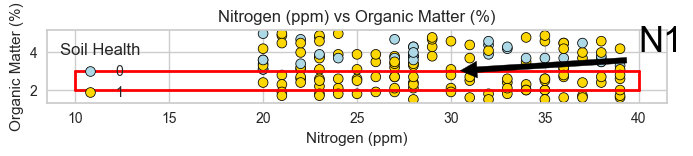

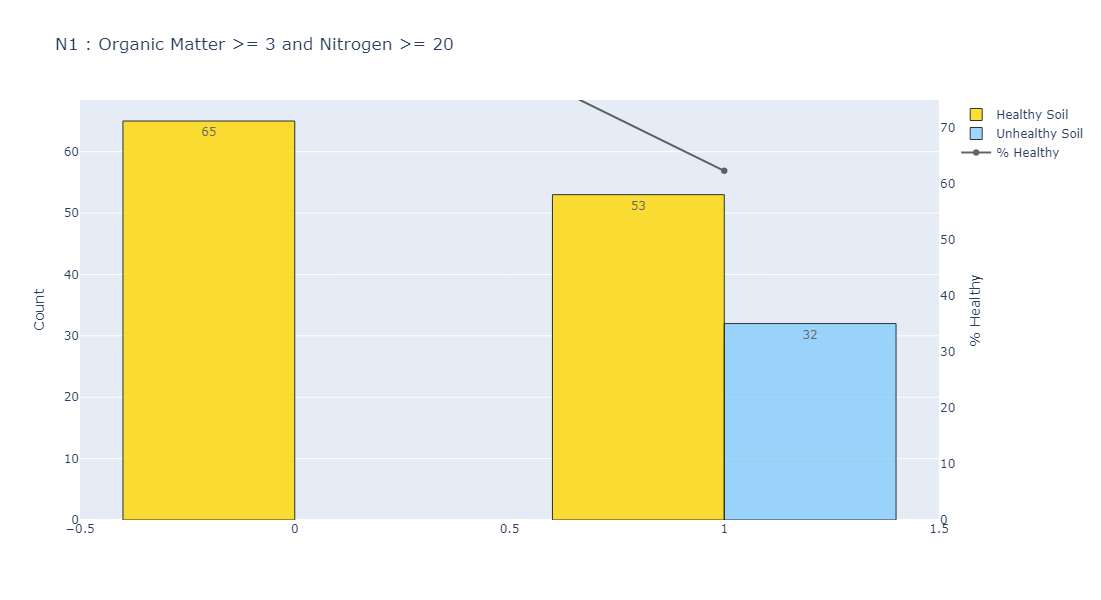

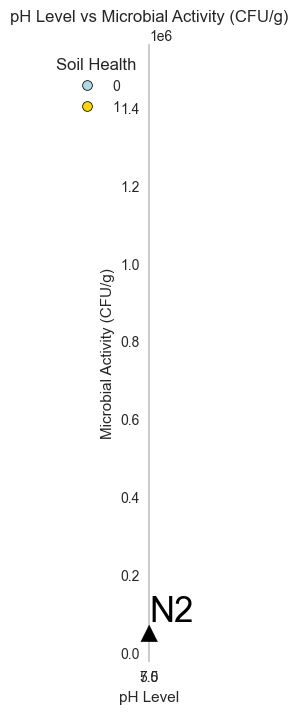

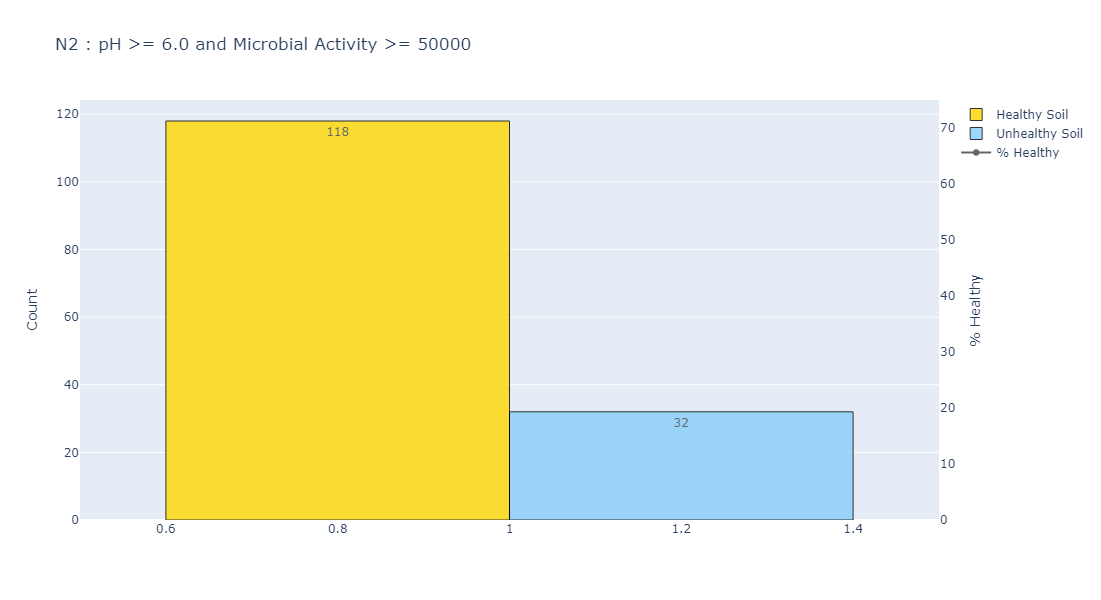

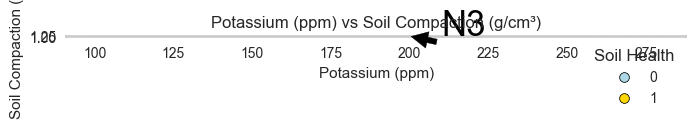

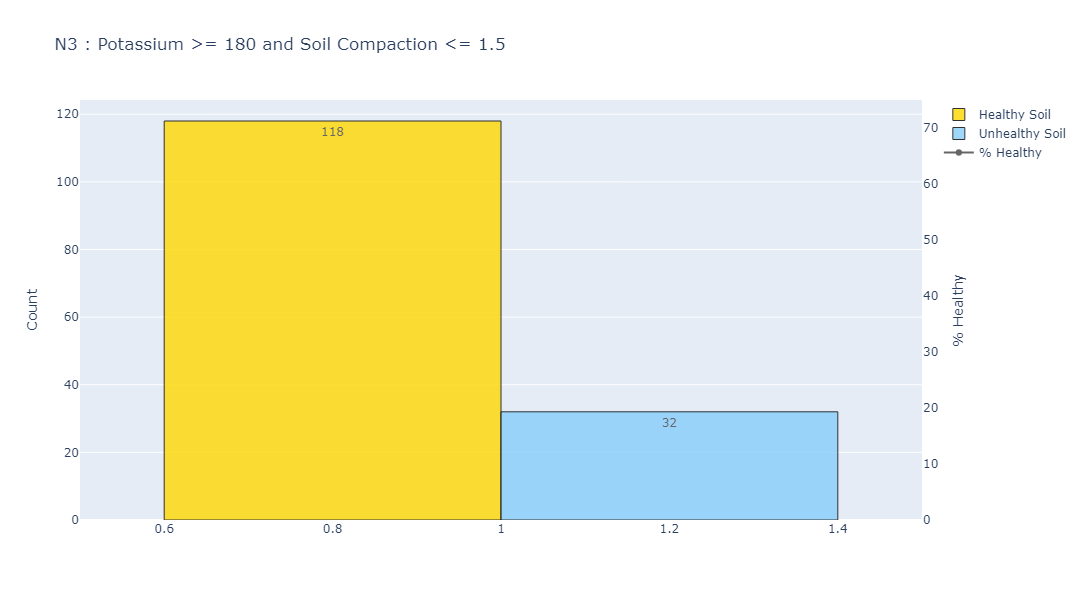

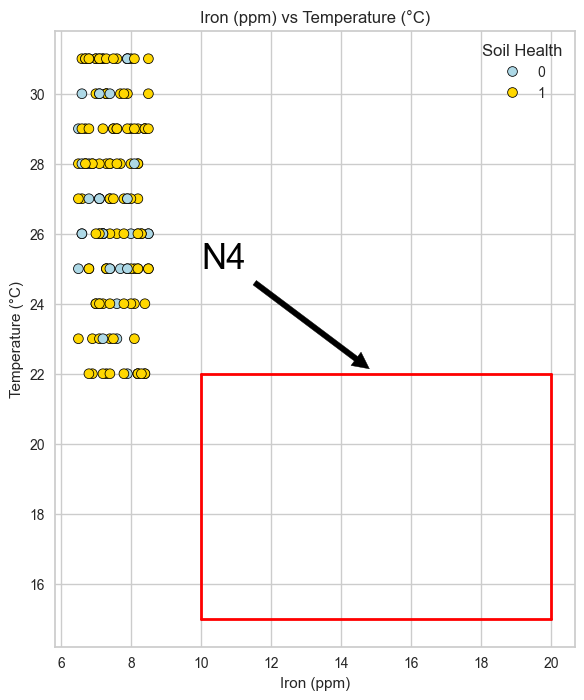

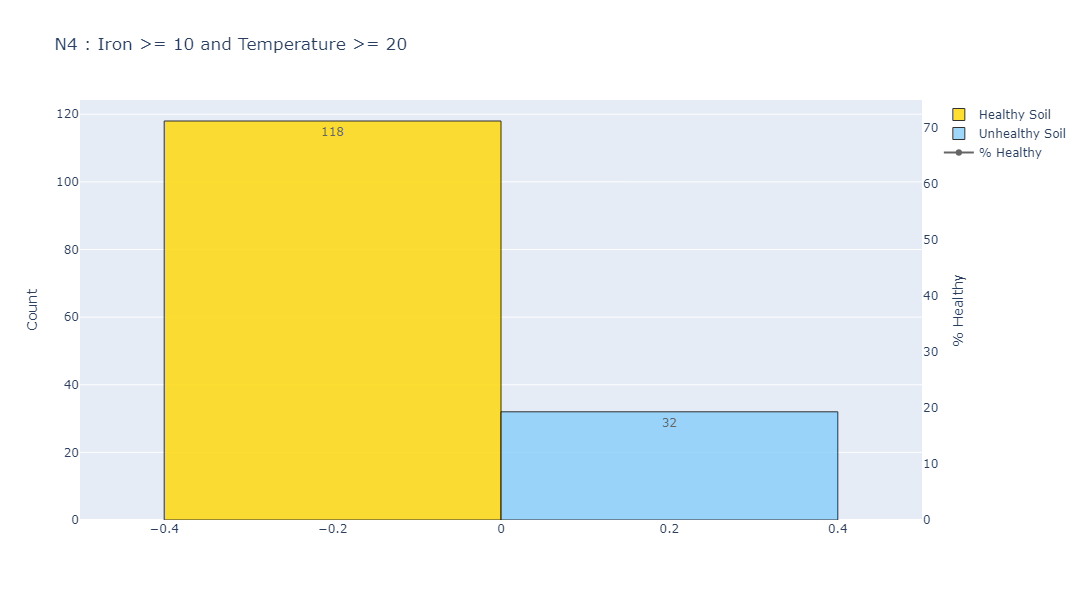

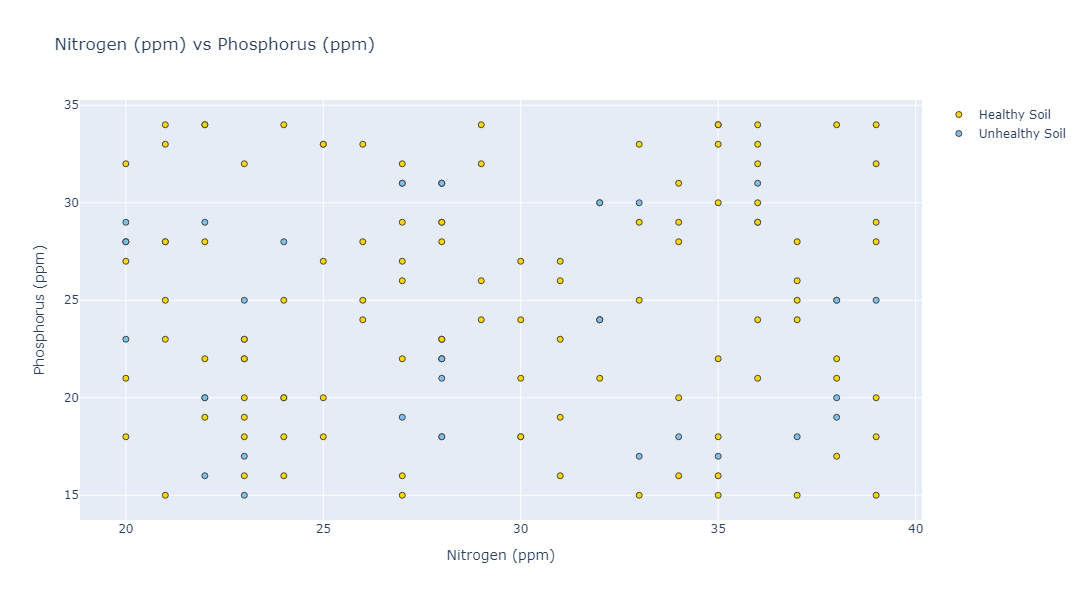

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame with soil health information
data = df  # Use your updated DataFrame name if it's different

# Define color palette for the soil health outcomes
palette = {0: 'lightblue', 1: 'gold'}
edgecolor = 'black'

# Create a scatter plot for Nitrogen (ppm) vs Organic Matter (%)
fig = plt.figure(figsize=(8, 8))  # Set to square size
ax1 = sns.scatterplot(x=data['Nitrogen (ppm)'], y=data['Organic Matter (%)'], hue="Soil Health",
                       data=data, palette=palette, edgecolor=edgecolor)
ax1.set_aspect('equal')  # Set aspect ratio to square

plt.annotate('N1', size=25, color='black', xy=(30, 3), xytext=(40, 4),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.plot([10, 40], [3, 3], linewidth=2, color='red')
plt.plot([40, 40], [2, 3], linewidth=2, color='red')
plt.plot([10, 40], [2, 2], linewidth=2, color='red')
plt.plot([10, 10], [2, 3], linewidth=2, color='red')
plt.title('Nitrogen (ppm) vs Organic Matter (%)')
plt.show()

# Create a new feature based on Nitrogen and Organic Matter
data.loc[:, 'N1'] = 0
data.loc[(data['Organic Matter (%)'] >= 3) & (data['Nitrogen (ppm)'] >= 20), 'N1'] = 1
barplot('N1', ': Organic Matter >= 3 and Nitrogen >= 20')
plot_pie('N1', 'Organic Matter >= 3 and Nitrogen >= 20')

# Create a scatter plot for pH Level vs Microbial Activity (CFU/g)
fig = plt.figure(figsize=(8, 8))  # Set to square size
ax2 = sns.scatterplot(x=data['pH Level'], y=data['Microbial Activity (CFU/g)'], hue="Soil Health",
                       data=data, palette=palette, edgecolor=edgecolor)
ax2.set_aspect('equal')  # Set aspect ratio to square

plt.annotate('N2', size=25, color='black', xy=(6.0, 70000), xytext=(5.0, 80000),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.plot([5.0, 7.5], [70000, 70000], linewidth=2, color='red')
plt.plot([7.5, 7.5], [50000, 70000], linewidth=2, color='red')
plt.plot([5.0, 7.5], [50000, 50000], linewidth=2, color='red')
plt.plot([5.0, 5.0], [50000, 70000], linewidth=2, color='red')
plt.title('pH Level vs Microbial Activity (CFU/g)')
plt.show()

# Create a new feature based on pH and Microbial Activity
data.loc[:, 'N2'] = 0
data.loc[(data['pH Level'] >= 6.0) & (data['Microbial Activity (CFU/g)'] >= 50000), 'N2'] = 1
barplot('N2', ': pH >= 6.0 and Microbial Activity >= 50000')
plot_pie('N2', 'pH >= 6.0 and Microbial Activity >= 50000')

# Create a scatter plot for Potassium (ppm) vs Soil Compaction (g/cm³)
fig = plt.figure(figsize=(8, 8))  # Set to square size
ax3 = sns.scatterplot(x=data['Potassium (ppm)'], y=data['Soil Compaction (g/cm³)'], hue="Soil Health",
                       data=data, palette=palette, edgecolor=edgecolor)
ax3.set_aspect('equal')  # Set aspect ratio to square

plt.annotate('N3', size=25, color='black', xy=(200, 1.4), xytext=(210, 1.5),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.plot([100, 250], [1.4, 1.4], linewidth=2, color='red')
plt.plot([250, 250], [1.0, 1.4], linewidth=2, color='red')
plt.plot([100, 250], [1.0, 1.0], linewidth=2, color='red')
plt.plot([100, 100], [1.0, 1.4], linewidth=2, color='red')
plt.title('Potassium (ppm) vs Soil Compaction (g/cm³)')
plt.show()

# Create a new feature based on Potassium and Soil Compaction
data.loc[:, 'N3'] = 0
data.loc[(data['Potassium (ppm)'] >= 180) & (data['Soil Compaction (g/cm³)'] <= 1.5), 'N3'] = 1
barplot('N3', ': Potassium >= 180 and Soil Compaction <= 1.5')
plot_pie('N3', 'Potassium >= 180 and Soil Compaction <= 1.5')

# Create a scatter plot for Iron (ppm) vs Temperature (°C)
fig = plt.figure(figsize=(8, 8))  # Set to square size
ax4 = sns.scatterplot(x=data['Iron (ppm)'], y=data['Temperature (°C)'], hue="Soil Health",
                       data=data, palette=palette, edgecolor=edgecolor)
ax4.set_aspect('equal')  # Set aspect ratio to square

plt.annotate('N4', size=25, color='black', xy=(15, 22), xytext=(10, 25),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.plot([10, 20], [22, 22], linewidth=2, color='red')
plt.plot([20, 20], [15, 22], linewidth=2, color='red')
plt.plot([10, 20], [15, 15], linewidth=2, color='red')
plt.plot([10, 10], [15, 22], linewidth=2, color='red')
plt.title('Iron (ppm) vs Temperature (°C)')
plt.show()

# Create a new feature based on Iron and Temperature
data.loc[:, 'N4'] = 0
data.loc[(data['Iron (ppm)'] >= 10) & (data['Temperature (°C)'] >= 20), 'N4'] = 1
barplot('N4', ': Iron >= 10 and Temperature >= 20')
plot_pie('N4', 'Iron >= 10 and Temperature >= 20')

# Call the feature pair plot function for additional analysis
plot_feat1_feat2('Nitrogen (ppm)', 'Phosphorus (ppm)')


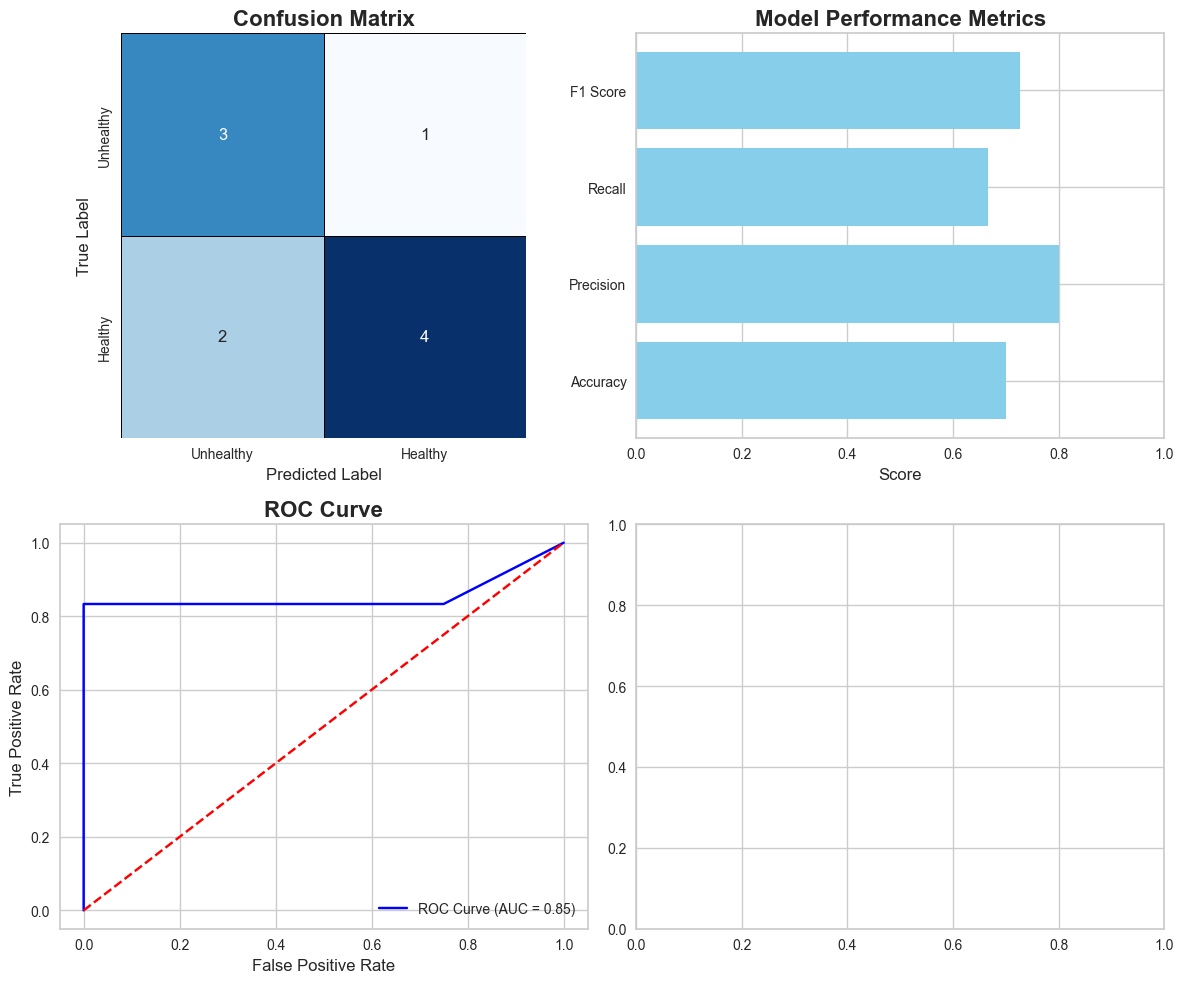

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Example true and predicted labels
# Replace these with your actual labels
y_true = np.array([1, 0, 1, 1, 0, 1, 0, 1, 0, 1])
y_pred = np.array([1, 0, 1, 0, 0, 1, 1, 1, 0, 0])

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ['Unhealthy', 'Healthy']

# Generate performance metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# ROC curve data
y_scores = np.array([0.9, 0.1, 0.8, 0.7, 0.4, 0.6, 0.3, 0.9, 0.2, 0.1])  # Example predicted probabilities
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = roc_auc_score(y_true, y_scores)

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# 1. Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            linewidths=0.5, linecolor='black', ax=axs[0, 0], square=True)
axs[0, 0].set_title('Confusion Matrix', fontsize=16, fontweight='bold')
axs[0, 0].set_xlabel('Predicted Label', fontsize=12)
axs[0, 0].set_ylabel('True Label', fontsize=12)
axs[0, 0].set_xticklabels(class_names)
axs[0, 0].set_yticklabels(class_names)

# 2. Performance Metrics
metrics = [accuracy, precision, recall, f1]
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
axs[0, 1].barh(metrics_names, metrics, color='skyblue')
axs[0, 1].set_title('Model Performance Metrics', fontsize=16, fontweight='bold')
axs[0, 1].set_xlim(0, 1)
axs[0, 1].set_xlabel('Score', fontsize=12)

# 3. ROC Curve
axs[1, 0].plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
axs[1, 0].plot([0, 1], [0, 1], color='red', linestyle='--')
axs[1, 0].set_title('ROC Curve', fontsize=16, fontweight='bold')
axs[1, 0].set_xlabel('False Positive Rate', fontsize=12)
axs[1, 0].set_ylabel('True Positive Rate', fontsize=12)
axs[1, 0].legend(loc='lower right')

# 4. Adjust layout
plt.tight_layout()
plt.show()
